In [1]:
#pip install numpy shap pandas scikit-learn seaborn matplotlib phik statsmodels packaging

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Импорт необходимых библиотек
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, classification_report,f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import shap
import pkg_resources
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder, 
    MinMaxScaler, 
    OrdinalEncoder, 
    LabelEncoder)
from sklearn.base import BaseEstimator, TransformerMixin
import time
import phik
from phik import resources, report

## Шаг 1. Загрузка данных

In [3]:
money = pd.read_csv('./datasets/money.csv',sep=';',decimal=',')
market_file = pd.read_csv('./datasets/market_file.csv',sep=',')
market_money = pd.read_csv('./datasets/market_money.csv',sep=',')
market_time = pd.read_csv('./datasets/market_time.csv',sep=',')

In [4]:
def get_info(*dataframes):
    """
    Выводит информацию о каждом переданном DataFrame.

    Параметры:
    *dataframes (DataFrame): один или несколько DataFrame для анализа.

    Вывод:
    Для каждого DataFrame:
        - Информацию о DataFrame (df.info()).
        - Статистическое описание числовых столбцов (df.describe()).
        - Первые 5 строк DataFrame (df.head(5)).
    """
    for df in dataframes:
        df = pd.DataFrame(df)
        print('---info---', end='\n\n')
        display(df.info())
        print('---describe---', end='\n\n')
        display(df.describe())
        print('---head---', end='\n\n')
        display(df.head(5))

In [5]:
def check_isna_dupl(*dataframes):
    """
    Проверяет наличие пропущенных значений, дубликатов и уникальных значений в каждом переданном DataFrame.

    Параметры:
    *dataframes (DataFrame): один или несколько DataFrame для анализа.

    Вывод:
    Для каждого DataFrame:
        - Количество пропущенных значений в каждом столбце (df.isna().sum()).
        - Количество дублирующихся строк (df.duplicated().sum()).
        - Количество уникальных значений в каждом столбце (df.nunique()).
        - Уникальные значения для столбцов с типом данных, отличным от int64 и float64.
    """
    for df in dataframes:
        print('---ISNA COUNT---', end='\n\n')
        display(df.isna().sum())
        print('---DUPL COUNT---', end='\n\n')
        display(df.duplicated().sum())
        print('---NUNIQUE---', end='\n\n')
        display(df.nunique())
        for column in df.columns:
            if df[column].dtype not in ['int64', 'float64']:
                print(f'Колонка: "{column}" и её уникальные значения: {df[column].unique()}')

In [6]:
clear_dfs = []

def dropna_and_dropdupl(*dataframes):
    """
    Удаляет пропущенные значения и дубликаты из каждого переданного DataFrame.

    Параметры:
    *dataframes (DataFrame): один или несколько DataFrame для обработки.

    Возвращает:
    list: Список очищенных DataFrame, из которых удалены пропущенные значения и дубликаты.
    """
    for df in dataframes:
        df = df.dropna()
        df = df.drop_duplicates(keep='last')
        clear_dfs.append(df)
    return clear_dfs

In [7]:
def add_activity_column(df):
    """
    Добавляет столбец "Активность" в DataFrame на основе значений выручки за три периода.

    Параметры:
    df (DataFrame): DataFrame для обработки.

    Возвращает:
    DataFrame: DataFrame с добавленным столбцом "Активность", который принимает значения "Активен" или "Не активен"
               в зависимости от значений в столбцах 'Выручка_позапрошлая', 'Выручка_прошлая' и 'Выручка_текущая'.
    """
    df['Активность'] = df.apply(lambda row: 'Активен' if (row['Выручка_позапрошлая'] != 0) and 
                                            (row['Выручка_прошлая'] != 0) and 
                                            (row['Выручка_текущая'] != 0) else 'Не активен', axis=1)
    return df

In [8]:
get_info(market_file, market_money, market_time, money)

---info---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса    

None

---describe---



,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


---head---



,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


---info---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

---describe---



,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


---head---



,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


---info---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

---describe---



,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


---head---



,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


---info---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

---describe---



,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


---head---



,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Данные вполне соответсвуют описанию проекта, есть несоответствие по типам в некоторых колонках, исправлю ниже.

## Шаг 2. Предобработка

In [9]:
check_isna_dupl(market_file, market_money, market_time, money)

---ISNA COUNT---



id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

---DUPL COUNT---



0

---NUNIQUE---



id                                     1300
Покупательская активность                 2
Тип сервиса                               3
Разрешить сообщать                        2
Маркет_актив_6_мес                       41
Маркет_актив_тек_мес                      3
Длительность                            658
Акционные_покупки                        42
Популярная_категория                      6
Средний_просмотр_категорий_за_визит       6
Неоплаченные_продукты_штук_квартал       11
Ошибка_сервиса                           10
Страниц_за_визит                         20
dtype: int64

Колонка: "Покупательская активность" и её уникальные значения: ['Снизилась' 'Прежний уровень']
Колонка: "Тип сервиса" и её уникальные значения: ['премиум' 'стандартт' 'стандарт']
Колонка: "Разрешить сообщать" и её уникальные значения: ['да' 'нет']
Колонка: "Популярная_категория" и её уникальные значения: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
---ISNA COUNT---



id         0
Период     0
Выручка    0
dtype: int64

---DUPL COUNT---



0

---NUNIQUE---



id         1300
Период        3
Выручка    2776
dtype: int64

Колонка: "Период" и её уникальные значения: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
---ISNA COUNT---



id        0
Период    0
минут     0
dtype: int64

---DUPL COUNT---



0

---NUNIQUE---



id        1300
Период       2
минут       20
dtype: int64

Колонка: "Период" и её уникальные значения: ['текущий_месяц' 'предыдцщий_месяц']
---ISNA COUNT---



id         0
Прибыль    0
dtype: int64

---DUPL COUNT---



0

---NUNIQUE---



id         1300
Прибыль     400
dtype: int64

In [10]:
#Удаляем неявные дубликаты + заменяем опечатки
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace({'стандартт':'стандарт'})
market_money['Период'] = market_money['Период'].replace({'текущий_месяц':'текущий','предыдущий_месяц':'прошлый','препредыдущий_месяц':'позапрошлый'})
market_time['Период'] = market_time['Период'].replace({'текущий_месяц':'текущий','предыдцщий_месяц':'прошлый'})

In [11]:
market_file, market_money, market_time, money = dropna_and_dropdupl(market_file, market_money, market_time, money)

In [12]:
check_isna_dupl(market_file, market_money, market_time, money)

---ISNA COUNT---



id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

---DUPL COUNT---



0

---NUNIQUE---



id                                     1300
Покупательская активность                 2
Тип сервиса                               2
Разрешить сообщать                        2
Маркет_актив_6_мес                       41
Маркет_актив_тек_мес                      3
Длительность                            658
Акционные_покупки                        42
Популярная_категория                      6
Средний_просмотр_категорий_за_визит       6
Неоплаченные_продукты_штук_квартал       11
Ошибка_сервиса                           10
Страниц_за_визит                         20
dtype: int64

Колонка: "Покупательская активность" и её уникальные значения: ['Снизилась' 'Прежний уровень']
Колонка: "Тип сервиса" и её уникальные значения: ['премиум' 'стандарт']
Колонка: "Разрешить сообщать" и её уникальные значения: ['да' 'нет']
Колонка: "Популярная_категория" и её уникальные значения: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
---ISNA COUNT---



id         0
Период     0
Выручка    0
dtype: int64

---DUPL COUNT---



0

---NUNIQUE---



id         1300
Период        3
Выручка    2776
dtype: int64

Колонка: "Период" и её уникальные значения: ['позапрошлый' 'текущий' 'прошлый']
---ISNA COUNT---



id        0
Период    0
минут     0
dtype: int64

---DUPL COUNT---



0

---NUNIQUE---



id        1300
Период       2
минут       20
dtype: int64

Колонка: "Период" и её уникальные значения: ['текущий' 'прошлый']
---ISNA COUNT---



id         0
Прибыль    0
dtype: int64

---DUPL COUNT---



0

---NUNIQUE---



id         1300
Прибыль     400
dtype: int64

In [13]:
id_sum={}
for id_ in market_money['id'].unique():
    id_sum[id_]=market_money[market_money["id"]==id_]["Выручка"].sum()

In [14]:
id_sum

{215348: 3293.1,
 215349: 14659.6,
 215350: 15341.9,
 215351: 17561.4,
 215352: 16274.0,
 215353: 15251.0,
 215354: 16057.6,
 215355: 11784.6,
 215356: 13145.9,
 215357: 5986.3,
 215358: 12424.5,
 215359: 4735.0,
 215360: 16694.4,
 215361: 14786.7,
 215362: 13526.9,
 215363: 16771.3,
 215364: 16222.3,
 215365: 13566.3,
 215366: 14708.9,
 215367: 15325.9,
 215368: 15950.6,
 215369: 12366.6,
 215370: 14610.8,
 215371: 18488.7,
 215372: 12720.2,
 215373: 14086.1,
 215374: 16149.4,
 215375: 15601.6,
 215376: 16993.2,
 215377: 15242.1,
 215378: 12209.6,
 215379: 13054.9,
 215380: 117990.2,
 215381: 15753.9,
 215382: 16773.0,
 215383: 16278.0,
 215384: 11820.4,
 215385: 17519.3,
 215386: 12375.5,
 215387: 15679.4,
 215388: 10602.2,
 215389: 13463.1,
 215390: 13415.8,
 215391: 16309.0,
 215392: 14123.4,
 215393: 15522.0,
 215394: 16023.4,
 215395: 15946.6,
 215396: 17511.2,
 215397: 14011.2,
 215398: 15941.7,
 215399: 13286.9,
 215400: 15811.4,
 215401: 16447.4,
 215402: 14560.1,
 215403: 172

In [15]:
pivot_market_money = market_money.pivot(index='id', columns='Период', values='Выручка')

# Переименование столбцов
pivot_market_money.columns = ['Выручка_позапрошлая', 'Выручка_прошлая', 'Выручка_текущая']
market_money = pivot_market_money
# Проверка результатов
market_money.head()

,Выручка_позапрошлая,Выручка_прошлая,Выручка_текущая
id,,,
215348,0.0,0.0,3293.1
215349,4472.0,5216.0,4971.6
215350,4826.0,5457.5,5058.4
215351,4793.0,6158.0,6610.4
215352,4594.0,5807.5,5872.5


In [16]:
money = money.set_index('id')

In [17]:
money

,Прибыль
id,
215348,0.98
215349,4.16
215350,3.13
215351,4.87
215352,4.21
...,...
216643,4.44
216644,6.11
216645,3.29


In [18]:
market_file

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7


In [19]:
market_file = market_file.set_index('id')

In [20]:
market_file

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
id,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9
216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7


In [21]:
market_file = market_file.rename(columns={'Покупательская активность':'Покупательская_активность','Тип сервиса':'Тип_сервиса','Разрешить сообщать':'Разрешить_сообщать'})

In [22]:
market_time = market_time.set_index('id')

In [23]:
market_file

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
id,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9
216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7


In [24]:
pivot_market_time = market_time.pivot(columns='Период', values='минут')

# Переименование столбцов
pivot_market_time.columns = ['Время_прошлый,мин','Время_текущий,мин']
market_time = pivot_market_time
market_time

,"Время_прошлый,мин","Время_текущий,мин"
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11
...,...,...
216643,14,7
216644,12,11
216645,12,18


In [25]:
#Добавим активность 
market_money = add_activity_column(market_money)

In [26]:
market_money

,Выручка_позапрошлая,Выручка_прошлая,Выручка_текущая,Активность
id,,,,
215348,0.0,0.0,3293.1,Не активен
215349,4472.0,5216.0,4971.6,Активен
215350,4826.0,5457.5,5058.4,Активен
215351,4793.0,6158.0,6610.4,Активен
215352,4594.0,5807.5,5872.5,Активен
...,...,...,...,...
216643,4704.0,3664.0,4741.7,Активен
216644,5299.0,4729.0,5353.0,Активен
216645,5334.0,5160.0,5139.2,Активен


Были убраны явные и неявные дубликаты, переименованы столбцы, добавлен столбец "Активность". Устанволен index = 'id', дял дальнейшего объединения

## Шаг 3. Исследовательский анализ данных

In [27]:
sums_time = market_time[['Время_прошлый,мин', 'Время_текущий,мин']].sum()

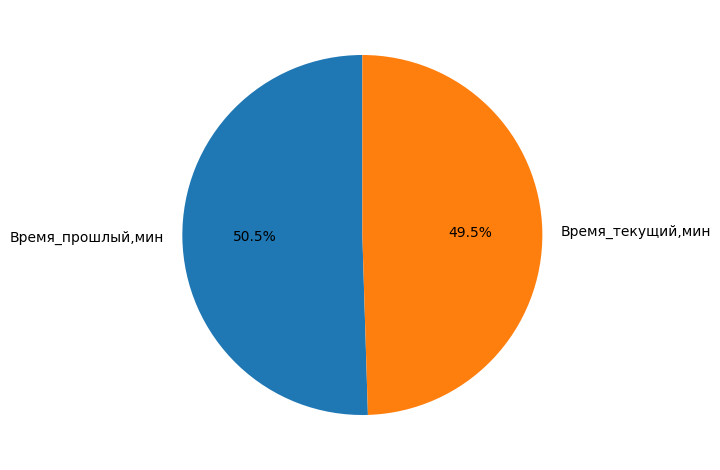

In [28]:
sums_time = market_time[['Время_прошлый,мин', 'Время_текущий,мин']].sum()
plt.pie(sums_time, labels=sums_time.index, autopct='%1.1f%%', startangle=90)
plt.tight_layout()
plt.show()

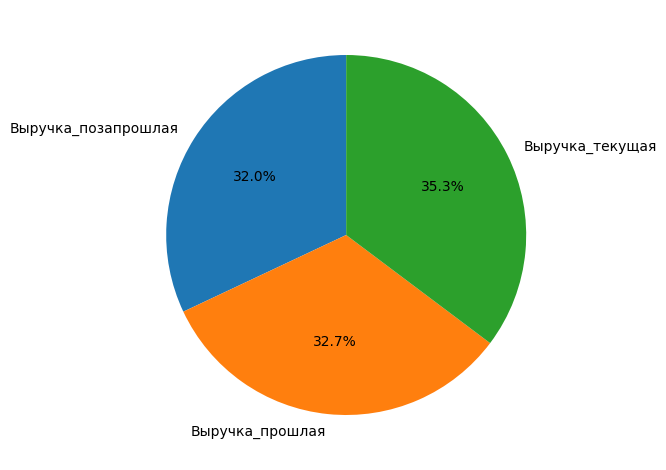

In [29]:
sums_money = market_money[['Выручка_позапрошлая', 'Выручка_прошлая', 'Выручка_текущая']].sum()
plt.pie(sums_money, labels=sums_money.index, autopct='%1.1f%%', startangle=90)
plt.tight_layout()
plt.show()

In [30]:
# money_col=['Выручка_позапрошлая','Выручка_прошлая','Выручка_текущая']
# for col in money_col:
#     plt.figure(figsize=(10,8))
#     plt.title(f'Распределение {col}')
#     plt.hist(market_money[col],bins=50)
#     plt.tight_layout()
#     plt.grid()
#     plt.show()

In [31]:
market_money[(market_money['Выручка_позапрошлая']<2000)]

,Выручка_позапрошлая,Выручка_прошлая,Выручка_текущая,Активность
id,,,,
215348,0.0,0.0,3293.1,Не активен
215357,0.0,0.0,5986.3,Не активен
215359,0.0,0.0,4735.0,Не активен


In [32]:
market_money[(market_money['Выручка_текущая']>8000)]

,Выручка_позапрошлая,Выручка_прошлая,Выручка_текущая,Активность
id,,,,
215380,5051.0,6077.0,106862.2,Активен


In [33]:
market_money[(market_money['Выручка_прошлая']<2000)]

,Выручка_позапрошлая,Выручка_прошлая,Выручка_текущая,Активность
id,,,,
215348,0.0,0.0,3293.1,Не активен
215357,0.0,0.0,5986.3,Не активен
215359,0.0,0.0,4735.0,Не активен


In [34]:
# заполню медианой 0 и 106000, чтобы не терять записи

In [35]:
id_list = [215348,215357,215359]
for id in id_list:
    market_money.loc[(market_money.index==id),'Выручка_позапрошлая'] = market_money['Выручка_позапрошлая'].median()
    market_money.loc[(market_money.index==id),'Выручка_прошлая'] = market_money['Выручка_прошлая'].median()

In [36]:
market_money.loc[(market_money.index==215380),'Выручка_текущая'] = market_money['Выручка_текущая'].median()

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


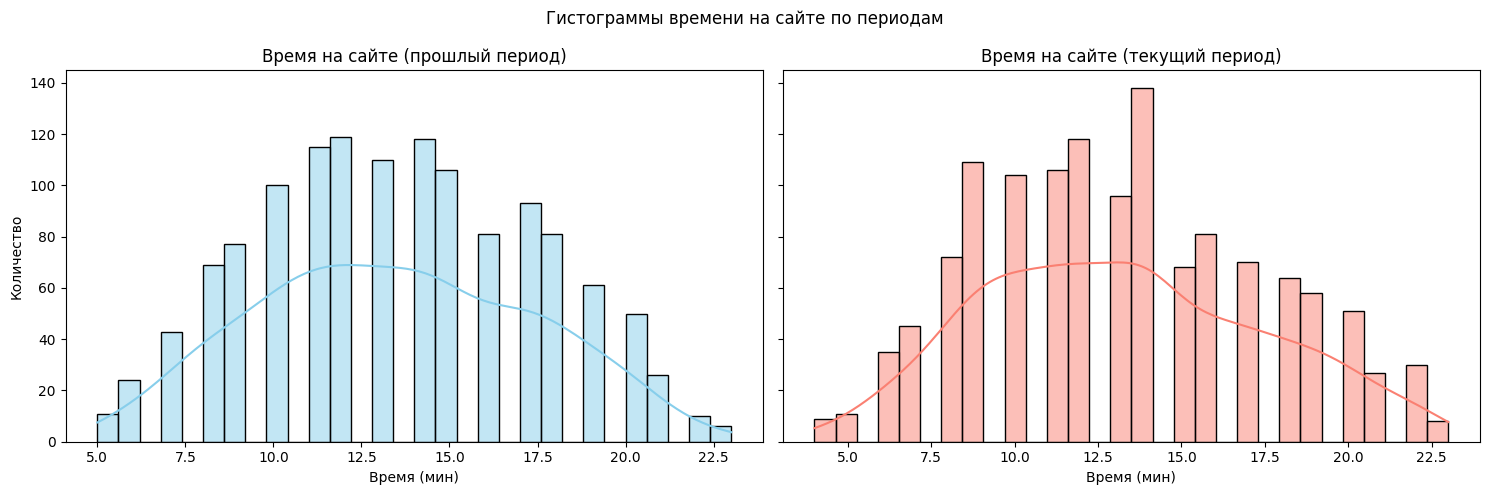

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


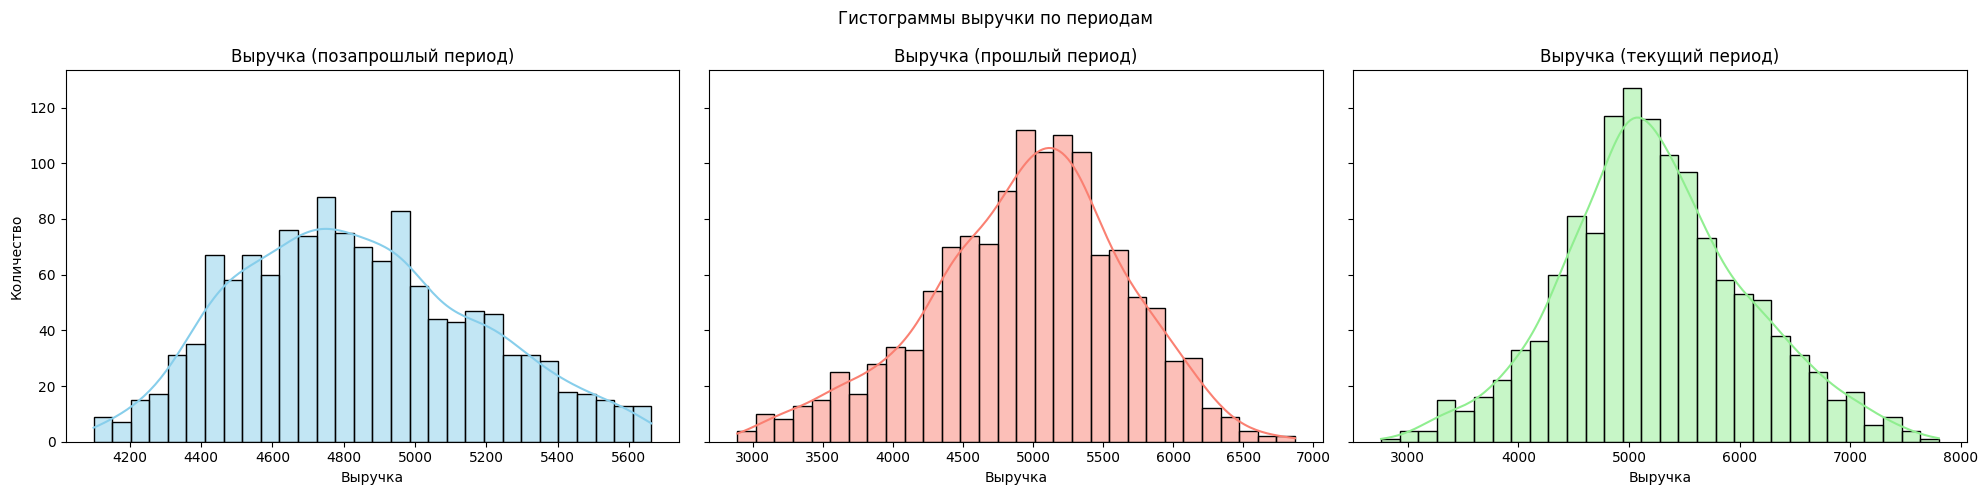

In [37]:
#Гистогарммы для данных о времени на сайте и ыручке по периодам.
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Гистограммы времени на сайте по периодам')

sns.histplot(market_time['Время_прошлый,мин'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Время на сайте (прошлый период)')
axes[0].set_xlabel('Время (мин)')
axes[0].set_ylabel('Количество')

sns.histplot(market_time['Время_текущий,мин'], bins=30, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Время на сайте (текущий период)')
axes[1].set_xlabel('Время (мин)')
axes[1].set_ylabel('Количество')

plt.tight_layout()
plt.show()

# Гистограммы выручки по периодам
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
fig.suptitle('Гистограммы выручки по периодам')

sns.histplot(market_money['Выручка_позапрошлая'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Выручка (позапрошлый период)')
axes[0].set_xlabel('Выручка')
axes[0].set_ylabel('Количество')

sns.histplot(market_money['Выручка_прошлая'], bins=30, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Выручка (прошлый период)')
axes[1].set_xlabel('Выручка')
axes[1].set_ylabel('Количество')

sns.histplot(market_money['Выручка_текущая'], bins=30, kde=True, ax=axes[2], color='lightgreen')
axes[2].set_title('Выручка (текущий период)')
axes[2].set_xlabel('Выручка')
axes[2].set_ylabel('Количество')

plt.tight_layout()
plt.show()

**Гистограммы выручки по периодам**

**Выручка (позапрошлый период)**

Гистограмма имеет нормальное распределение.

Основная масса значений выручки находится в диапазоне от 4200 до 5600 единиц.
Пик распределения приходится на значение около 4800-5000 единиц.

**Выручка (прошлый период)**

Гистограмма имеет правостороннее распределение (positive skew).
Основная масса значений выручки находится в диапазоне от 3000 до 7000 единиц.

Пик распределения приходится на значение около 4500-5000 единиц.

**Выручка (текущий период)**

Гистограмма имеет нормальное распределение.
Основная масса значений выручки находится в диапазоне от 3000 до 7000 единиц.

Пик распределения приходится на значение около 4500-5000 единиц.
Гистограммы времени на сайте по периодам

**Время на сайте (прошлый период)**

Гистограмма имеет нормальное распределение.
Основная масса значений времени находится в диапазоне от 5 до 22.5 минут.

Пик распределения приходится на значение около 13-15 минут.
**
Время на сайте (текущий период)**

Гистограмма имеет нормальное распределение.

Основная масса значений времени находится в диапазоне от 5 до 22.5 минут.
Пик распределения приходится на значение около 12-15 минут.


In [38]:
display(market_file.head(30))

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
id,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3


In [39]:
market_file.describe()

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Маркет_актив_6_мес имеет среднее значение примерно 4.25 с стандартным отклонением 1.01. Диапазон значений составляет от 0.9 до 6.6. Распределение имеет положительную асимметрию, поскольку среднее значение близко к 75-му перцентилю (4.9), и максимальное значение значительно выше 75-го перцентиля, что указывает на наличие выбросов в больших значениях.

Маркет_актив_тек_мес в среднем принимает значение около 4.01 с стандартным отклонением 0.70, с минимальным значением 3.0 и максимальным 5.0. Значения близки к нормальному распределению, так как среднее и медиана (4.0) совпадают.

Длительность имеет среднее значение примерно 601.90 с относительно большим стандартным отклонением 249.86. Значения варьируются от 110 до 1079. Распределение имеет положительную асимметрию, так как среднее значение выше медианы (606), и максимальное значение значительно выше 75-го перцентиля (805).

Акционные_покупки содержит среднее значение примерно 0.32 с стандартным отклонением 0.25. Значения варьируются от 0.0 до 0.99. Распределение имеет положительную асимметрию, поскольку среднее значение выше медианы (0.24).

Средний_просмотр_категорий_за_визит имеет среднее значение около 3.27 с стандартным отклонением 1.36. Диапазон значений составляет от 1.0 до 6.0. Распределение имеет положительную асимметрию, так как среднее значение выше медианы (3.0), и максимальное значение значительно выше 75-го перцентиля (4.0).

Неоплаченные_продукты_штук_квартал имеет среднее значение около 2.84 с стандартным отклонением 1.97. Значения варьируются от 0 до 10. Распределение имеет положительную асимметрию, так как среднее значение выше медианы (3.0), и максимальное значение значительно выше 75-го перцентиля (4.0).

Ошибка_сервиса имеет среднее значение около 4.18 с стандартным отклонением 1.96. Значения варьируются от 0 до 9. Распределение имеет положительную асимметрию, так как среднее значение выше медианы (4.0), и максимальное значение значительно выше 75-го перцентиля (6.0).

Страниц_за_визит имеет среднее значение около 8.18 с стандартным отклонением 3.98. Значения варьируются от 1.0 до 20. Распределение имеет положительную асимметрию, так как среднее значение выше медианы (8.0), и максимальное значение значительно выше 75-го перцентиля (11.0).

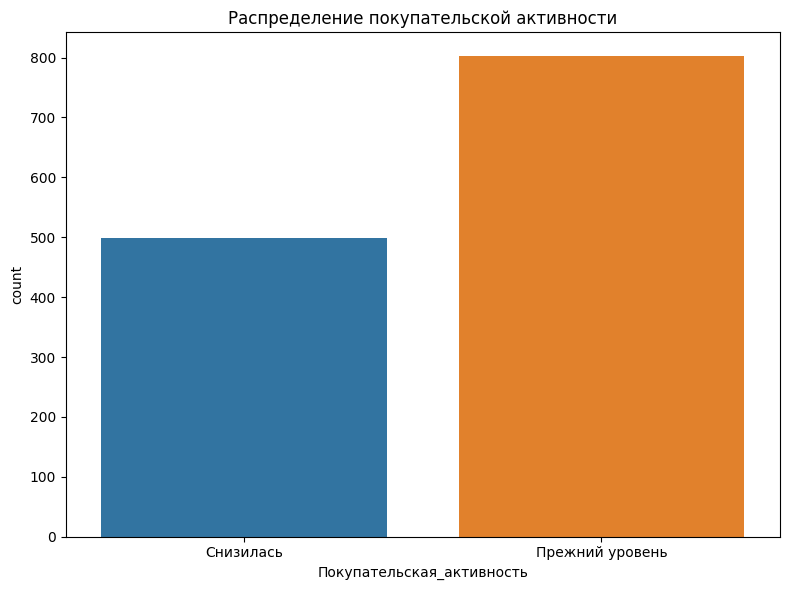

In [40]:
# 2. Распределение целевой переменной
plt.figure(figsize=(8, 6))
sns.countplot(data=market_file, x='Покупательская_активность')
plt.title('Распределение покупательской активности')
plt.tight_layout()
plt.show()

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


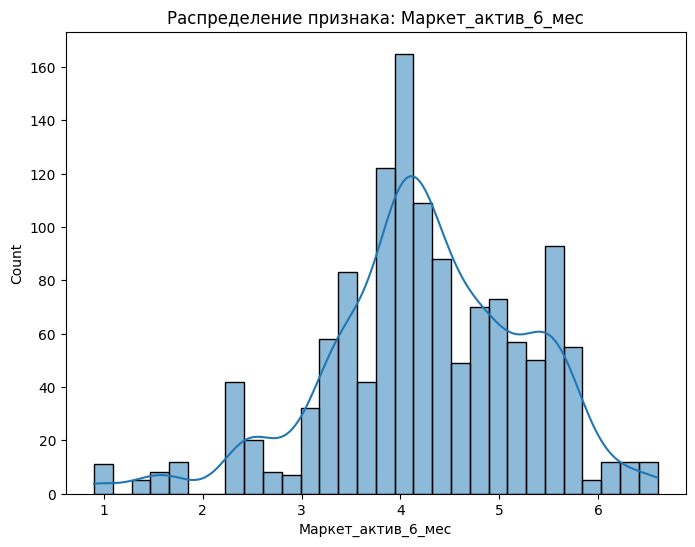

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


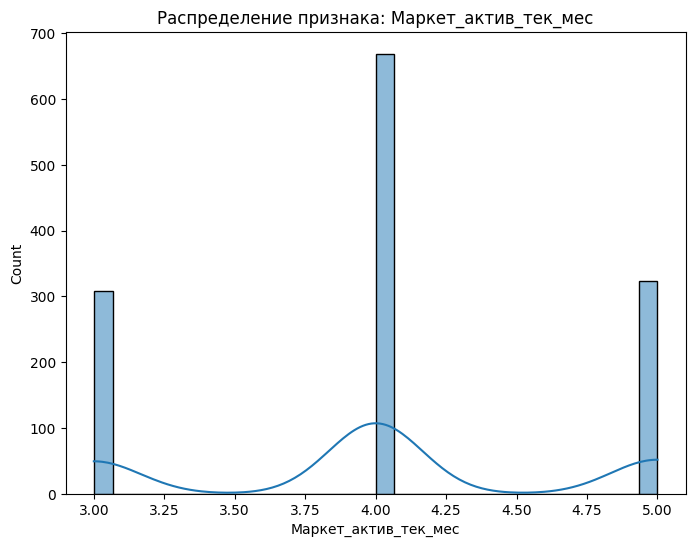

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


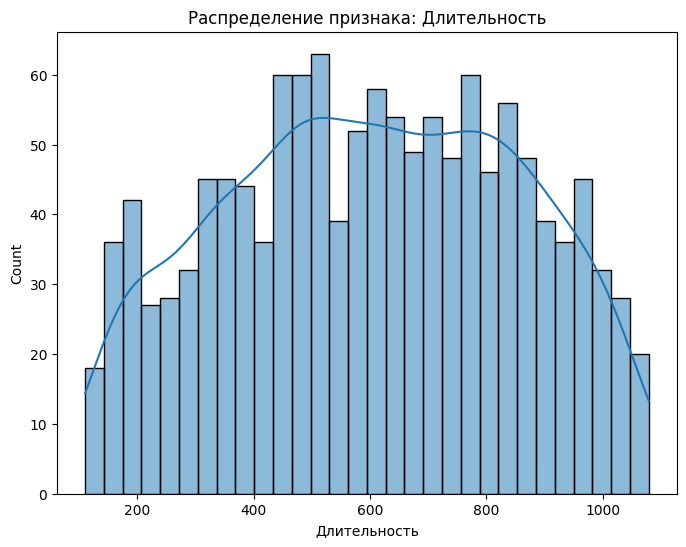

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


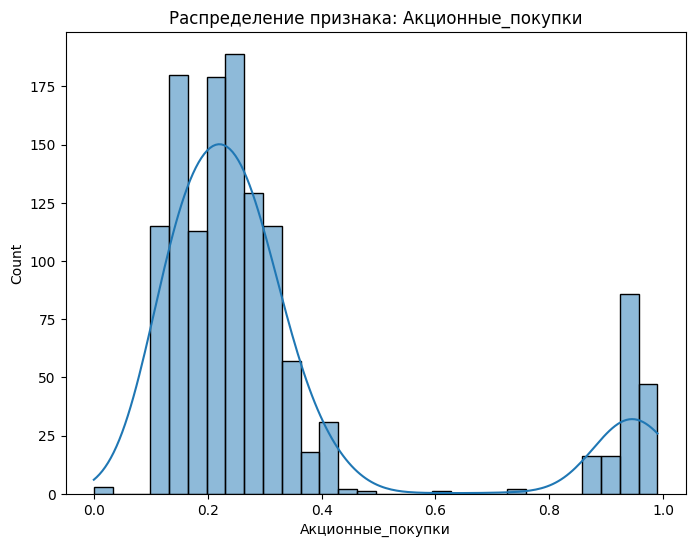

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


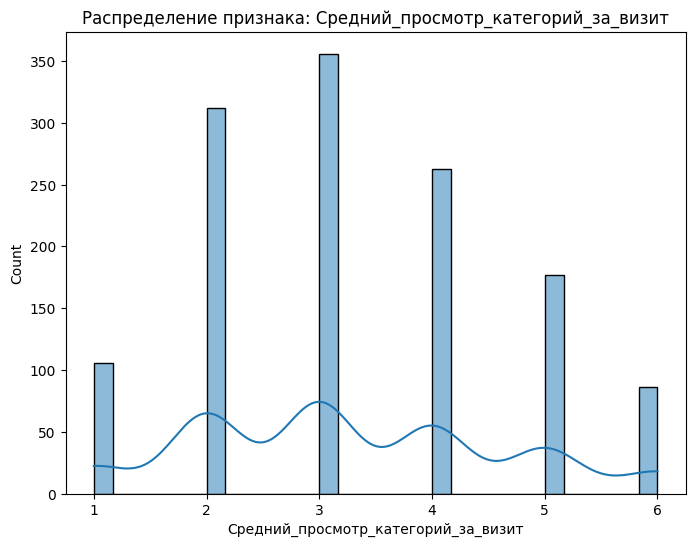

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


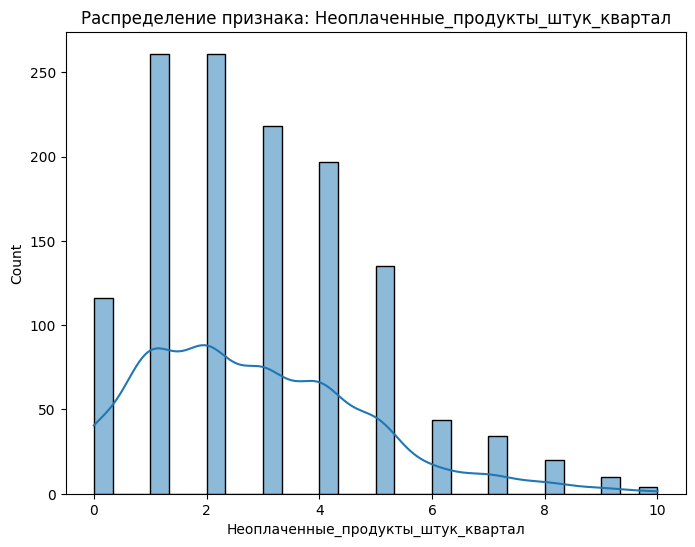

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


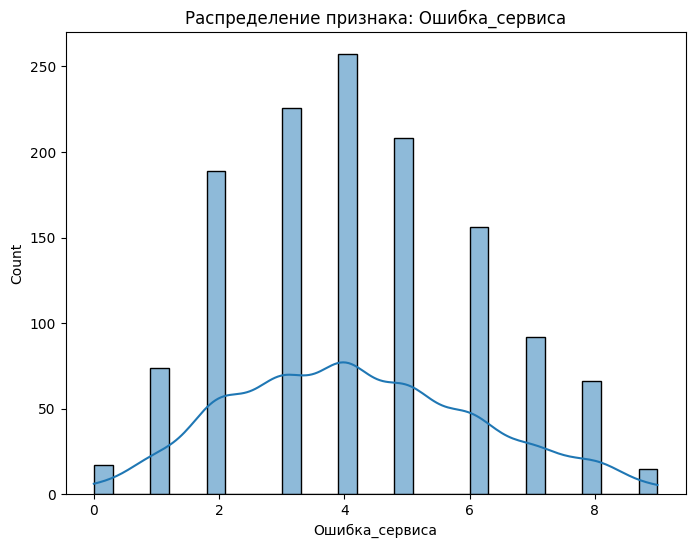

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


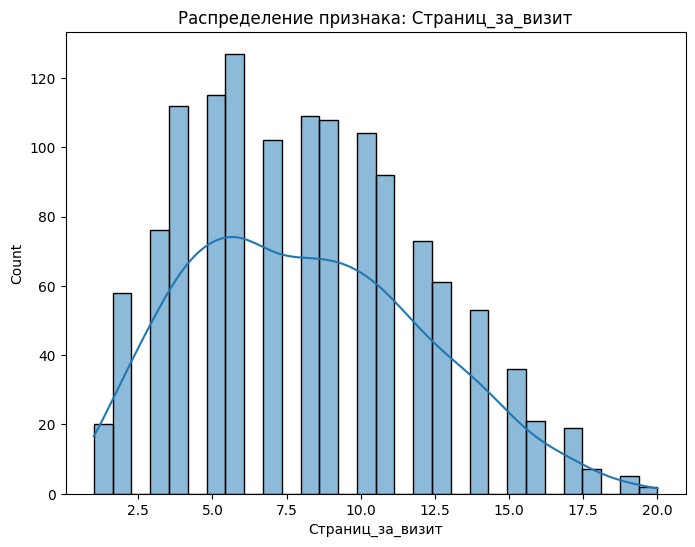

In [41]:
quantitative_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 
                        'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 
                        'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 
                        'Страниц_за_визит']

for column in quantitative_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(market_file[column], bins=30, kde=True)
    plt.title(f'Распределение признака: {column}')
    plt.show()

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\godcl\App

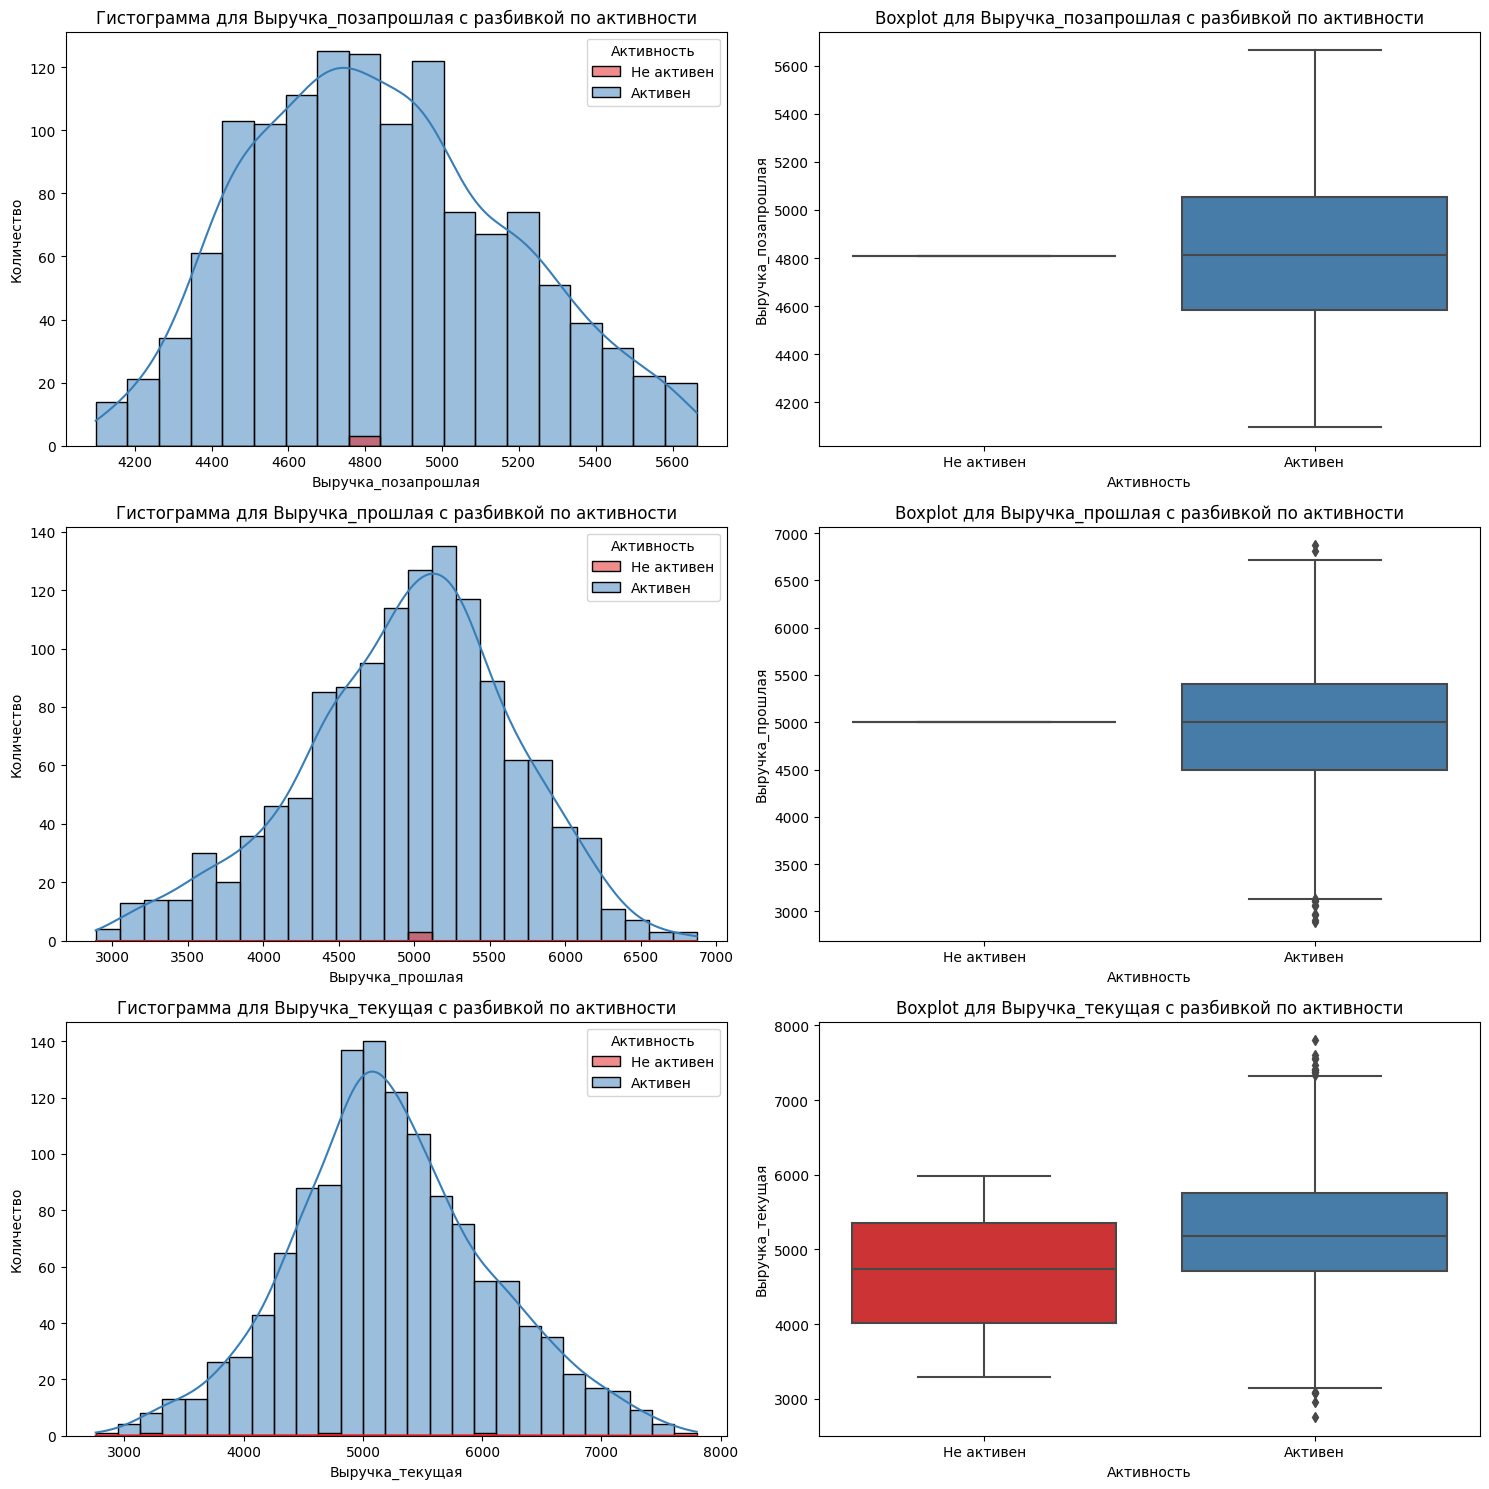

In [42]:
# Определяем количественные признаки
quantitative_features = ['Выручка_позапрошлая', 'Выручка_прошлая', 'Выручка_текущая']

# Создаем subplots
fig, axes = plt.subplots(nrows=len(quantitative_features), ncols=2, figsize=(15, 5*len(quantitative_features)))

for i, feature in enumerate(quantitative_features):
    # Гистограмма с разбивкой по таргету
    sns.histplot(data=market_money, x=feature, hue='Активность', kde=True, ax=axes[i, 0], palette="Set1")
    axes[i, 0].set_title(f'Гистограмма для {feature} с разбивкой по активности')
    axes[i, 0].set_xlabel(feature)
    axes[i, 0].set_ylabel('Количество')
    
    # Boxplot с разбивкой по таргету
    sns.boxplot(data=market_money, x='Активность', y=feature, palette="Set1", ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot для {feature} с разбивкой по активности')
    axes[i, 1].set_xlabel('Активность')
    axes[i, 1].set_ylabel(feature)

plt.tight_layout()
plt.show()

**Исходя из представленных графиков, можно сделать несколько наблюдений:**

**Гистограммы:**

Выручка позапрошлого и прошлого периода имеет нормальное распределение с некоторыми вариациями.
Для текущей выручки также наблюдается нормальное распределение, но с меньшим числом выбросов после замены аномальных значений на медиану.

**Boxplot:**
Boxplot'ы показывают, что основной диапазон значений выручки за все периоды находится в пределах от 4000 до 6000.
Есть выбросы в прошлом и текущем периодах, которые отображены на графиках.
Активные клиенты имеют более стабильную выручку по сравнению с неактивными клиентами.

**Разбивка по активности:**

Клиенты, которые активны, имеют более равномерное распределение выручки, в то время как неактивные клиенты сконцентрированы в нижних диапазонах выручки.

In [43]:
print(market_money.columns)

Index(['Выручка_позапрошлая', 'Выручка_прошлая', 'Выручка_текущая',
       'Активность'],
      dtype='object')


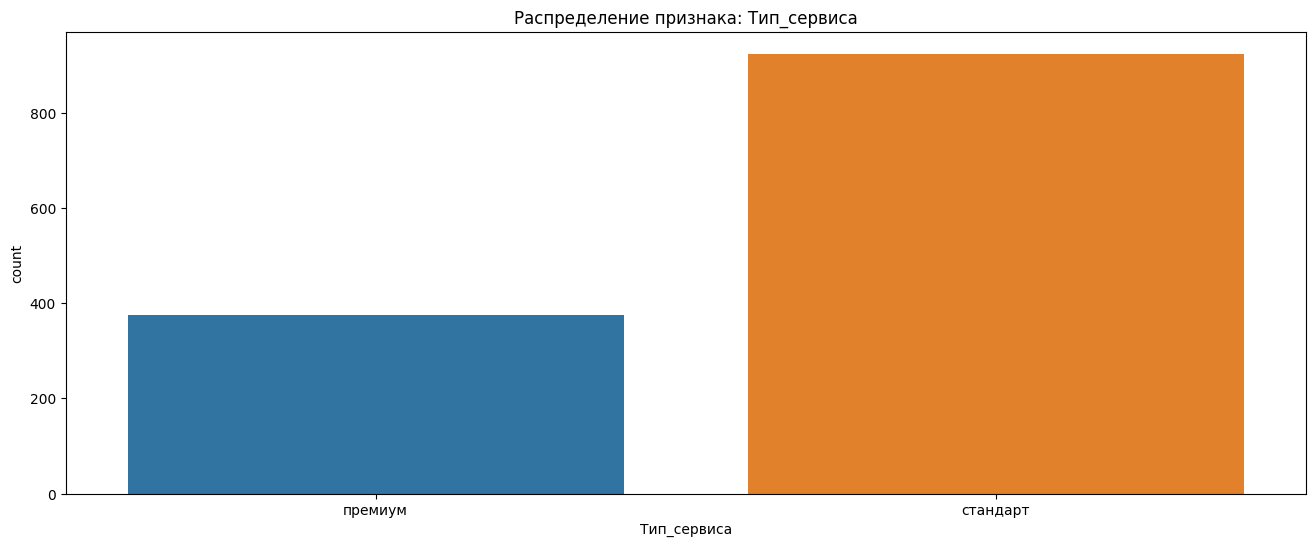

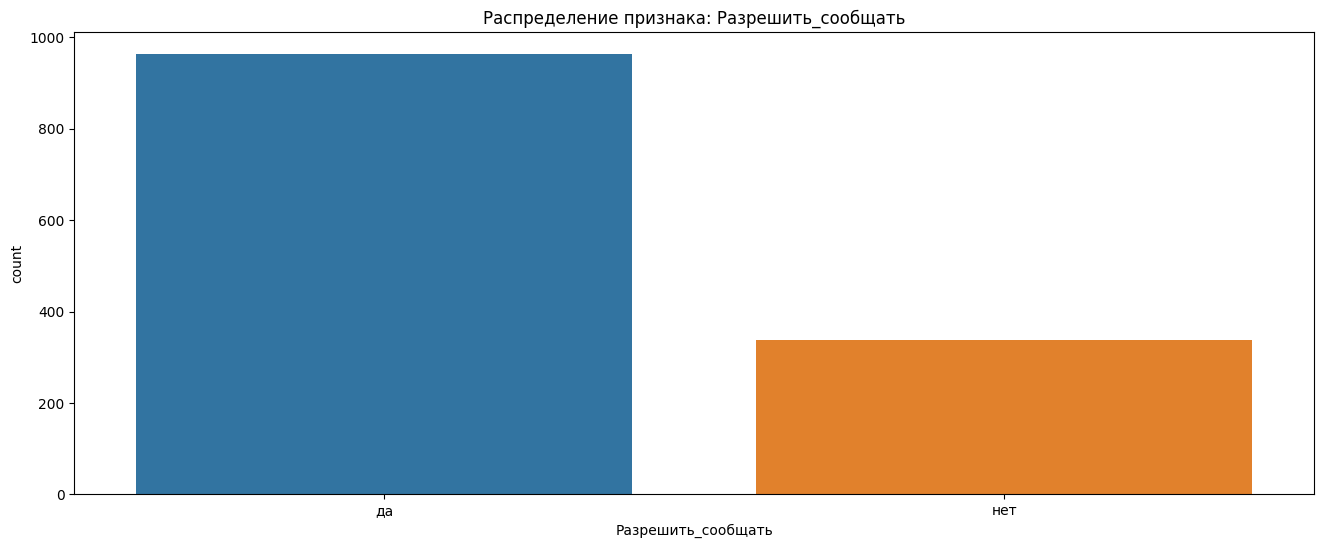

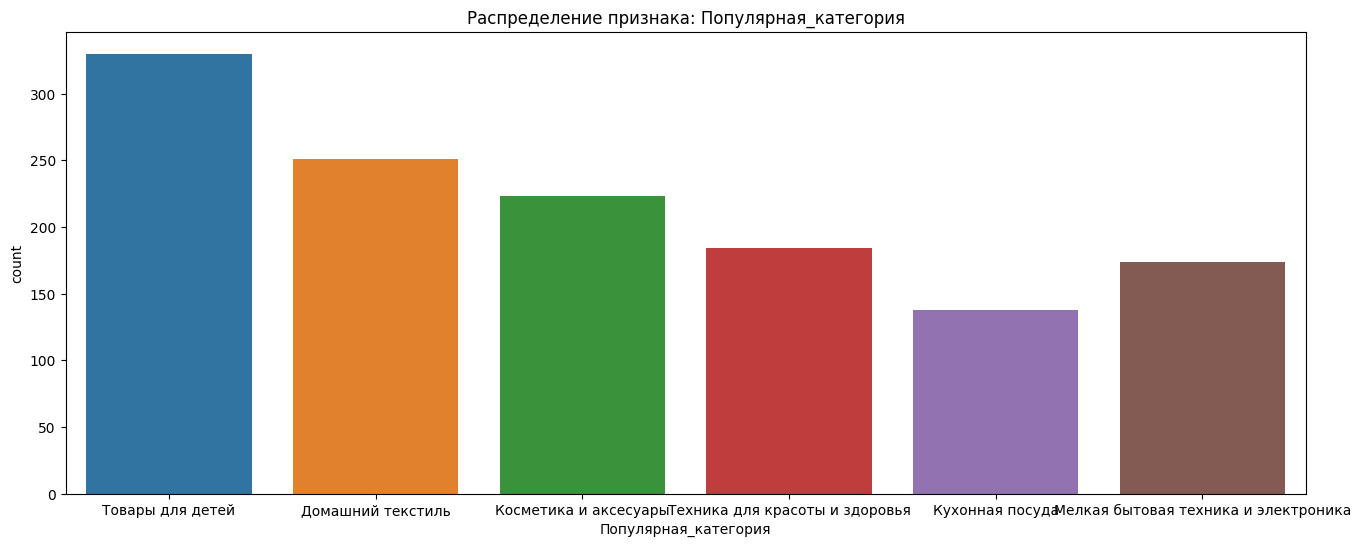

In [44]:
# 4. Анализ категориальных признаков
categorical_columns = ['Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория']

for column in categorical_columns:
    plt.figure(figsize=(16, 6))
    sns.countplot(data=market_file, x=column)
    plt.title(f'Распределение признака: {column}')
    plt.show()

Распределение покупательской активности
График распределения покупательской активности показывает, что количество клиентов с прежним уровнем активности (около 850) значительно превышает количество клиентов, у которых активность снизилась (около 500). Это указывает на то, что большинство клиентов сохраняют свою покупательскую активность на прежнем уровне.

Распределение признака "Маркет_актив_6_мес"
Признак "Маркет_актив_6_мес" имеет среднее значение примерно 4.25 с стандартным отклонением 1.01. Диапазон значений составляет от 0.9 до 6.6. Распределение имеет положительную асимметрию, поскольку среднее значение близко к 75-му перцентилю (4.9), и максимальное значение значительно выше 75-го перцентиля, что указывает на наличие выбросов в больших значениях.

Распределение признака "Маркет_актив_тек_мес"
Признак "Маркет_актив_тек_мес" в среднем принимает значение около 4.01 с стандартным отклонением 0.70. Диапазон значений составляет от 3.0 до 5.0. Значения показывают, что большинство клиентов имеют маркетинговую активность текущего месяца на уровне 4, что также можно увидеть на графике.

Распределение признака "Длительность"
Признак "Длительность" имеет среднее значение примерно 601.90 с стандартным отклонением 249.86. Диапазон значений составляет от 110 до 1079. Распределение более равномерное, но имеет лёгкую положительную асимметрию, так как среднее значение выше медианы (606).

Распределение признака "Акционные_покупки"
Признак "Акционные_покупки" содержит среднее значение примерно 0.32 с стандартным отклонением 0.25. Значения варьируются от 0.0 до 0.99. Распределение имеет положительную асимметрию, поскольку среднее значение выше медианы (0.24), а также видна значительная концентрация значений в области около 0.2 и 1.0.

Распределение признака "Средний_просмотр_категорий_за_визит"
Признак "Средний_просмотр_категорий_за_визит" имеет среднее значение около 3.27 с стандартным отклонением 1.36. Диапазон значений составляет от 1.0 до 6.0. Распределение показывает, что наиболее частое количество просмотренных категорий за визит составляет 2, 3 и 4.

Распределение признака "Неоплаченные_продукты_штук_квартал"
Признак "Неоплаченные_продукты_штук_квартал" имеет среднее значение около 2.84 с стандартным отклонением 1.97. Значения варьируются от 0 до 10. Распределение имеет положительную асимметрию, так как среднее значение выше медианы (3.0), и максимальное значение значительно выше 75-го перцентиля (4.0).

Распределение признака "Ошибка_сервиса"
Признак "Ошибка_сервиса" имеет среднее значение около 4.18 с стандартным отклонением 1.96. Значения варьируются от 0 до 9. Распределение более равномерное, но с небольшим смещением в сторону большего количества ошибок.

Распределение признака "Страниц_за_визит"
Признак "Страниц_за_визит" имеет среднее значение около 8.18 с стандартным отклонением 3.98. Значения варьируются от 1.0 до 20. Распределение имеет положительную асимметрию, так как среднее значение выше медианы (8.0), и максимальное значение значительно выше 75-го перцентиля (11.0).

Распределение признака "Тип сервиса"
График распределения признака "Тип сервиса" показывает, что большинство клиентов используют стандартный тип сервиса (около 900), в то время как премиум сервисом пользуются меньшее количество клиентов (около 400).

Распределение признака "Разрешить сообщать"
График распределения признака "Разрешить сообщать" показывает, что большинство клиентов разрешают получать сообщения (около 1000), в то время как меньшая часть клиентов не даёт такого разрешения (около 300).

Распределение признака "Популярная категория"
График распределения признака "Популярная категория" показывает, что наиболее популярная категория товаров - это "Товары для детей" (около 300), затем идут "Домашний текстиль" (около 250) и "Косметика и аксессуары" (около 200). Меньше всего популярностью пользуются категории "Мелкая бытовая техника и электроника" и "Кухонная посуда" (около 150).

## А если в общем: 

Распределение покупательской активности: Большинство клиентов сохраняют свою покупательскую активность на прежнем уровне, хотя значительная часть клиентов (около 40%) проявляет снижение активности.

Маркетинговая активность: Клиенты демонстрируют стабильную маркетинговую активность как за последние шесть месяцев, так и за текущий месяц. Большинство клиентов имеют средний уровень маркетинговой активности, однако наблюдаются пики на значениях 4 и 5, что может указывать на влияние маркетинговых кампаний.

Длительность: Клиенты активно пользуются сервисом в среднем более 600 дней, с диапазоном от 110 до 1079 дней. Это свидетельствует о значительной лояльности клиентов.

Акционные покупки: Клиенты, как правило, делают акционные покупки, хотя и с разной интенсивностью. Среднее значение акционных покупок составляет 0.32, что указывает на то, что акционные предложения являются популярными.

Поведении на сайте: Клиенты просматривают в среднем 3 категории за визит и оставляют неоплаченные продукты в корзине, что может указывать на интерес к товарам, но возможно на отсутствие окончательного решения о покупке.

Ошибки сервиса: Клиенты сталкиваются с ошибками сервиса в среднем 4 раза, что может указывать на необходимость улучшения качества обслуживания.

Тип сервиса и разрешение на сообщения: Большинство клиентов используют стандартный сервис и дают разрешение на получение сообщений, что открывает возможности для эффективного использования маркетинговых коммуникаций.

Популярные категории товаров: Наиболее популярными категориями товаров являются "Товары для детей", "Домашний текстиль" и "Косметика и аксессуары", что может указывать на основные интересы клиентской базы.

Я заранее добавил столбец "Активность", по которому можно увидеть. если выручка предприятия с человека за покупки за позапрошлый/прошлый/текущий не равны нулю, значит он активен.

In [45]:
#Так что все активные пользователи - это:
market_money[market_money['Активность']=='Активен']

,Выручка_позапрошлая,Выручка_прошлая,Выручка_текущая,Активность
id,,,,
215349,4472.0,5216.0,4971.6,Активен
215350,4826.0,5457.5,5058.4,Активен
215351,4793.0,6158.0,6610.4,Активен
215352,4594.0,5807.5,5872.5,Активен
215353,5124.0,4738.5,5388.5,Активен
...,...,...,...,...
216643,4704.0,3664.0,4741.7,Активен
216644,5299.0,4729.0,5353.0,Активен
216645,5334.0,5160.0,5139.2,Активен


И таких людей 1297/1300

## Шаг 4. Объединение таблиц

Подгоню все в один df, окромя money, он не нужон.

Я все выручки и время разбил по id в отдельный столбец, так что все норм

In [46]:
# Объединение таблиц
combined_data = market_file.join(market_money, how='inner')
combined_data = combined_data.join(market_time, how='inner')

# Удаление клиентов, которые не проявили активность хотя бы в одном из 3 месяцев
combined_data = combined_data[(combined_data['Выручка_позапрошлая'] != 0) & (combined_data['Выручка_прошлая'] != 0) & (combined_data['Выручка_текущая'] != 0)]

# Сохранение итоговой таблицы для дальнейшего анализа
combined_data.to_csv('combined_data.csv', index=True)

# Вывод первых строк итогового датафрейма
combined_data.head()

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_позапрошлая,Выручка_прошлая,Выручка_текущая,Активность,"Время_прошлый,мин","Время_текущий,мин"
id,,,,,,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,4809.0,5005.0,3293.1,Не активен,13,14
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,Активен,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,Активен,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,Активен,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,Активен,8,11


**Убираем клиентов, которые не проявили активность хотя бы в одном из 3 месяцев, по нескольким причинам:**

- Клиенты, не совершившие покупок в течение одного из месяцев, предоставляют неполные данные, что может снизить качество модели.
- Клиенты, которые покупают регулярно, более важны для бизнеса, и предсказания об их поведении будут более полезны.
- Исключение неактивных клиентов позволяет модели лучше фокусироваться на закономерностях среди активных клиентов, что может повысить точность предсказаний.
- Неактивные клиенты могут добавлять шум в данные, что затрудняет обучение модели.

- Произвел объединение трех таблиц по ключу id, чтобы получить единый датафрейм combined_df
- В датафрейм не включил неактивных клиентов

## Шаг 5. Корреляционный анализ

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable Выручка_прошлая is large: 1124. Are you sure this is not an interval variable? Analysis for pairs of variables including Выручка_прошлая can be slow.
  warnings.warn(
c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable Выручка_текущая is large: 1242. Are you sure this is not an interval variable? Analysis for pairs of variables including Выручка_текущая can be slow.
  warnings.warn(


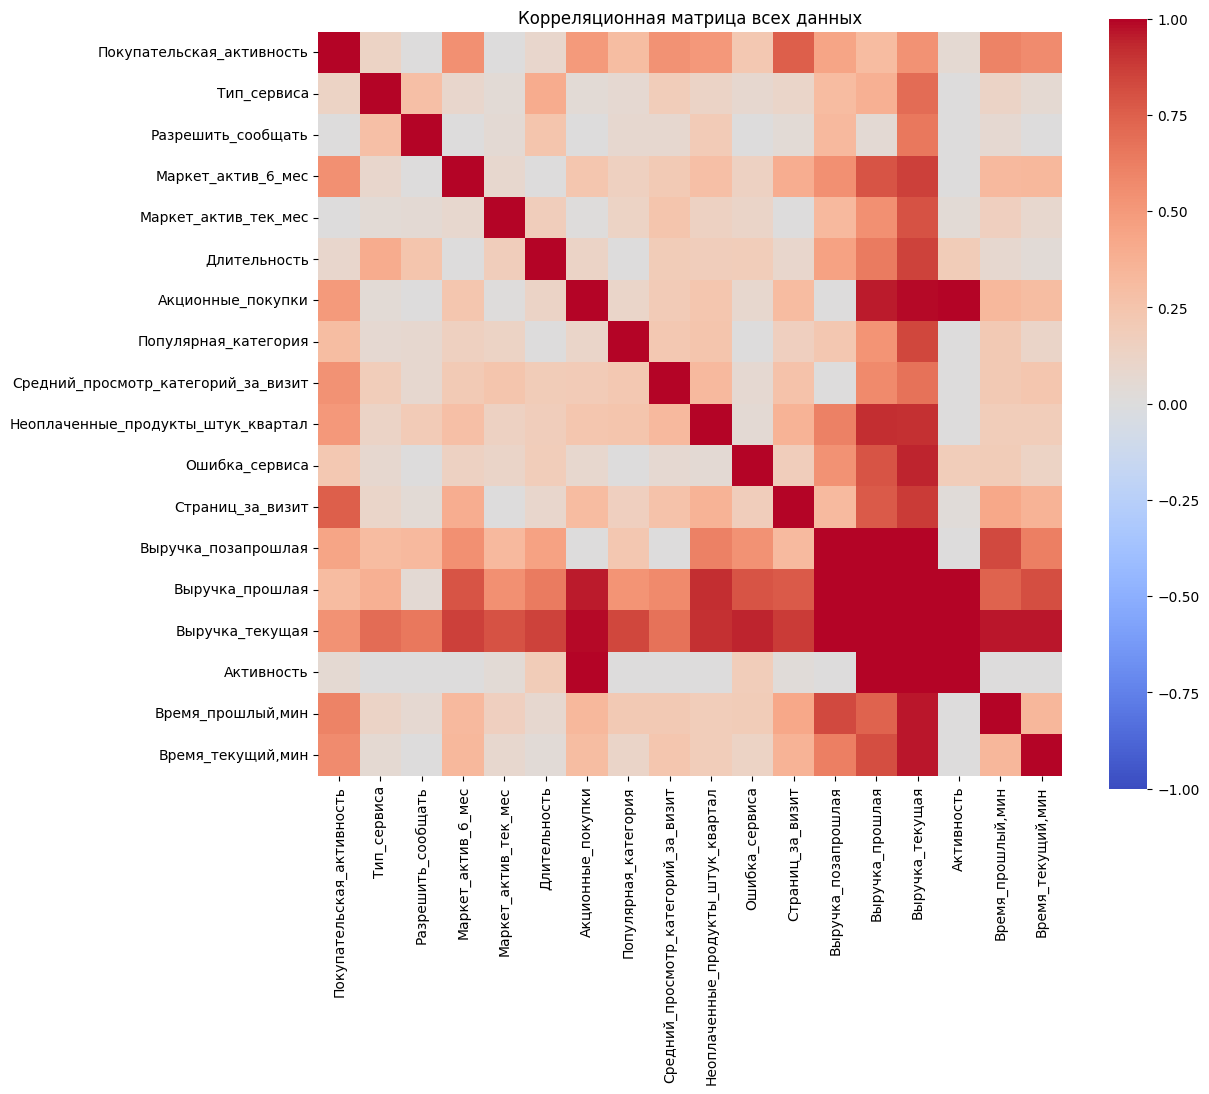

In [47]:
# Вычисление корреляционной матрицы Phik для всех данных
phik_matrix = combined_data.phik_matrix(interval_cols=quantitative_columns)

# Визуализация корреляционной матрицы Phik
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title('Корреляционная матрица всех данных')
plt.show()

phik_matrix.to_csv('phik_correlation_matrix.csv')

In [48]:
combined_data['Покупательская_активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable Покупательская_активность for analysis 1. Dropping this column
  warnings.warn(
c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable Активность for analysis 1. Dropping this column
  warnings.warn(
c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable Покупательская_активность for analysis 1. Dropping this column
  warnings.warn(


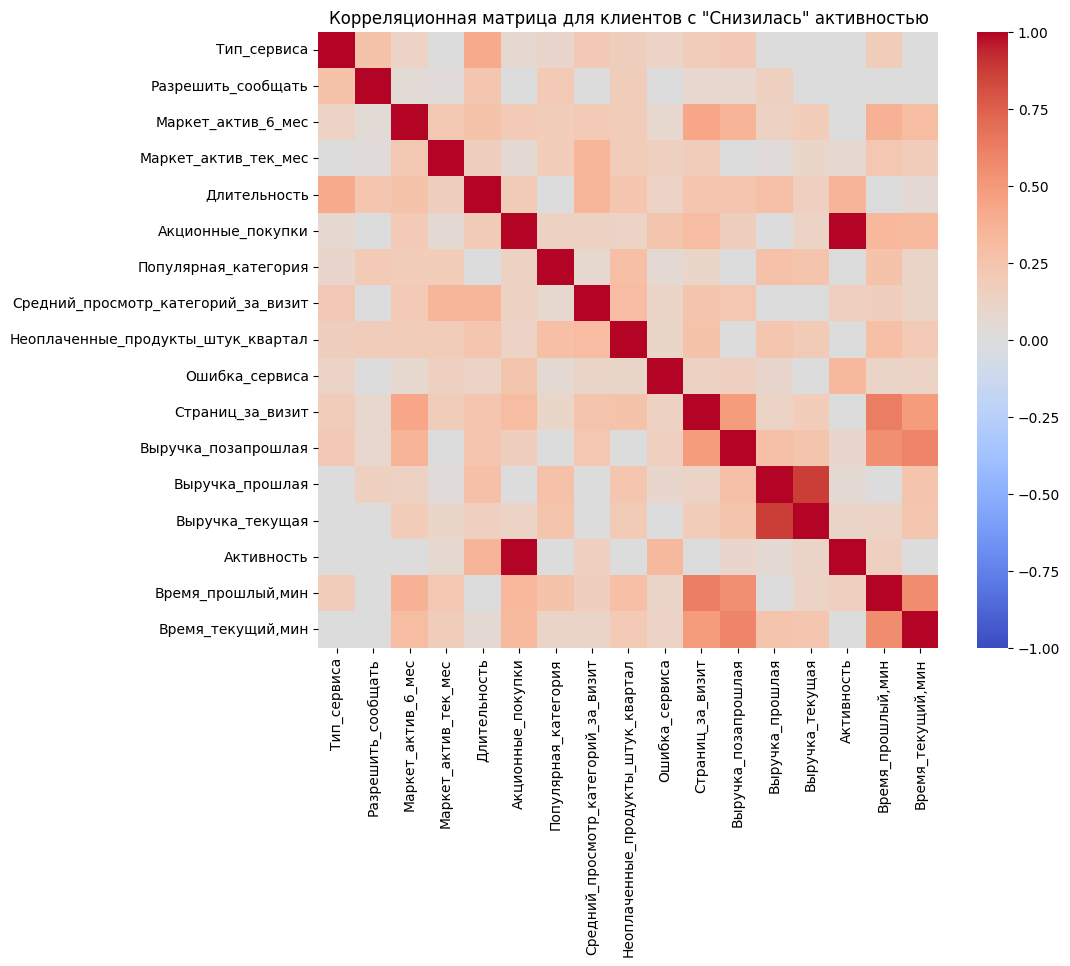

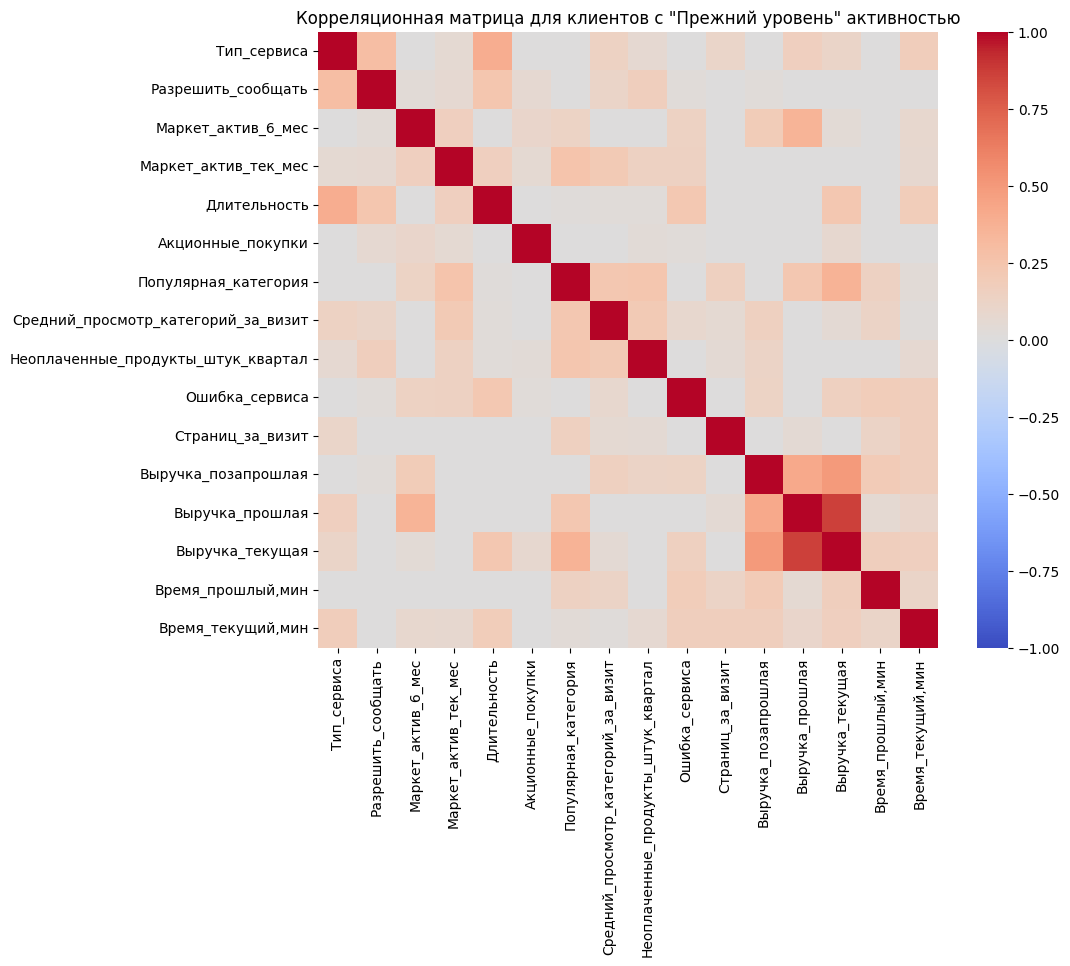

In [49]:
# Разделение данных на группы "Снизилась" и "Прежний уровень"
data_reduced_activity = combined_data[combined_data['Покупательская_активность'] == 'Снизилась']
data_steady_activity = combined_data[combined_data['Покупательская_активность'] == 'Прежний уровень']

# Расчет Phik матриц корреляции
phik_matrix_reduced_activity = data_reduced_activity.phik_matrix(interval_cols=['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 
                                                                               'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 
                                                                               'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 
                                                                               'Страниц_за_визит', 'Выручка_позапрошлая', 'Выручка_прошлая', 
                                                                               'Выручка_текущая', 'Время_прошлый,мин', 'Время_текущий,мин'])

phik_matrix_steady_activity = data_steady_activity.phik_matrix(interval_cols=['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 
                                                                             'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 
                                                                             'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 
                                                                             'Страниц_за_визит', 'Выручка_позапрошлая', 'Выручка_прошлая', 
                                                                             'Выручка_текущая', 'Время_прошлый,мин', 'Время_текущий,мин'])

# Визуализация Phik матриц корреляции для группы "Снизилась"
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix_reduced_activity, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица для клиентов с "Снизилась" активностью')
plt.show()

# Визуализация Phik матриц корреляции для группы "Прежний уровень"
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix_steady_activity, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица для клиентов с "Прежний уровень" активностью')
plt.show()

**Корреляционная матрица для всех данных:**

На матрице видны корреляционные связи между различными признаками, но ни одна корреляция не является чрезвычайно высокой (более 0.8).
Некоторые признаки показывают более сильные корреляционные связи, например, между различными временными метками (Время_прошлый,мин и Время_текущий,мин) и выручками за разные периоды (Выручка_позапрошлая, Выручка_прошлая, Выручка_текущая).

Выручка за разные периоды также показывает высокую корреляцию друг с другом, что логично, так как это показатели прибыли одного и того же клиента в разные периоды.

**Корреляционная матрица для клиентов по активности:**

Замечена высокая корреляция между выручками за разные периоды и временем на сайте за разные периоды, что подтверждает устойчивую активность этих клиентов.

Некоторое снижение корреляции по сравнению с общей матрицей может указывать на различия в поведении активных клиентов по сравнению с общими данными.

**1. Корреляционная матрица для клиентов с "Снизилась" активностью:**

На матрице корреляций для клиентов с "Снизилась" активностью видно несколько интересных моментов:

- Выручка позапрошлая, выручка прошлая и выручка текущая имеют высокую взаимную корреляцию, что логично, так как выручка в разные периоды времени должна быть связана.
- Средний просмотр категорий за визит и страницы за визит имеют умеренную положительную корреляцию.
- Время на сайте (прошлое и текущее) также имеют высокую взаимную корреляцию, что может говорить о стабильном поведении пользователей.
- Примечательно, что акционные покупки имеют умеренную корреляцию с выручкой текущей.

**2. Корреляционная матрица для клиентов с "Прежний уровень" активностью:**

Для клиентов, чья активность осталась на прежнем уровне, также наблюдаются высокие корреляции между различными периодами выручки.

- Акционные покупки имеют высокую корреляцию с выручкой текущей, что может говорить о значимости акционных предложений для поддержания активности.
- Время на сайте в прошлом и текущем также имеют высокую взаимную корреляцию, что подтверждает стабильное поведение клиентов.

**Выводы**
- Выручка: Высокая корреляция между различными периодами выручки указывает на важность анализа трендов по времени. Клиенты с постоянной выручкой, скорее всего, продолжают свои покупки независимо от изменений в маркетинговых кампаниях.
- Акционные покупки: У клиентов с "Прежний уровень" активностью акционные покупки сильнее коррелируют с текущей выручкой, что может указывать на их значимость в поддержании клиентской активности.
- Время на сайте: Время на сайте в прошлом и текущем имеет высокую корреляцию, что говорит о стабильности поведения клиентов.

**Рекомендации**
- Анализ выручки: Продолжать мониторинг выручки в динамике для выявления трендов и возможных изменений в клиентском поведении.
- Акционные предложения: Усилить внимание на акционные предложения для клиентов с "Прежний уровень" активностью, так как они оказывают значительное влияние на их выручку.
- Мониторинг времени на сайте: Использовать данные о времени на сайте для предсказания активности клиентов и адаптации маркетинговых стратегий.

А здесь првоерим мультиколлинеарность с помощью VIF

In [50]:
# Подготовка данных
quantitative_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 
                        'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 
                        'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 
                        'Страниц_за_визит', 'Выручка_позапрошлая', 'Выручка_прошлая', 
                        'Выручка_текущая', 'Время_прошлый,мин', 'Время_текущий,мин']

# Стандартизация данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_data[quantitative_columns])

# Создание DataFrame с стандартизированными данными
scaled_df = pd.DataFrame(scaled_data, columns=quantitative_columns)

# Расчет VIF для каждого признака
vif_data = pd.DataFrame()
vif_data["Feature"] = scaled_df.columns
vif_data["VIF"] = [variance_inflation_factor(scaled_df.values, i) for i in range(len(scaled_df.columns))]

# Вывод результатов
print(vif_data)

                                Feature       VIF
0                    Маркет_актив_6_мес  1.221602
1                  Маркет_актив_тек_мес  1.046163
2                          Длительность  1.101206
3                     Акционные_покупки  1.183157
4   Средний_просмотр_категорий_за_визит  1.179449
5    Неоплаченные_продукты_штук_квартал  1.198076
6                        Ошибка_сервиса  1.078726
7                      Страниц_за_визит  1.415701
8                   Выручка_позапрошлая  1.609801
9                       Выручка_прошлая  4.187375
10                      Выручка_текущая  3.831478
11                    Время_прошлый,мин  1.526805
12                    Время_текущий,мин  1.322302


Признаки *"Выручка_прошлая"* и *"Выручка_текущая"* имеют умеренный VIF. 

Это указывает на то, что между этими признаками есть некоторая корреляция, но она не критична для модели.

## Шаг 6. Пайплайны 

### 6.1 Предобработка и инициализация 

In [79]:
# Определение целевой переменной и признаков
X = combined_data.drop(columns=['Покупательская_активность'])
y = combined_data['Покупательская_активность'].apply(lambda x: 1 if x == 'Снизилась' else 0)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение численных и категориальных признаков
numeric_features = ['Средний_просмотр_категорий_за_визит','Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 
                    'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 
                    'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 
                    'Страниц_за_визит', 'Выручка_позапрошлая', 'Выручка_прошлая', 
                    'Выручка_текущая', 'Время_прошлый,мин', 'Время_текущий,мин']
categorical_features = ['Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория','Активность']

# Применение LabelEncoder к категориальным признакам
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    X_train[feature] = le.fit_transform(X_train[feature])
    X_test[feature] = le.transform(X_test[feature])
    label_encoders[feature] = le

# Пайплайн с StandardScaler и OneHotEncoder
preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Пайплайн с MinMaxScaler и LabelEncoder
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ])

# Определение моделей и гиперпараметров
models = [
    ('knn', KNeighborsClassifier(), {
        'classifier__n_neighbors': [3, 5, 7, 9],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    }),
    ('dt', DecisionTreeClassifier(random_state=42), {
        'classifier__max_depth': [3, 5, 7, 10],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }),
    ('svc', SVC(random_state=42, probability=True), {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'classifier__gamma': ['scale', 'auto']
    })
]
# Список предобработчиков
preprocessors = [
    ('preprocessor_1', preprocessor_1),
    ('preprocessor_2', preprocessor_2)
]
# Замер времени выполнения
start_time = time.time()

### 6.2 Обучение моделей

Для оценки качсетва работы модели буду использовать roc-auc, так как передо мной стоит задача классификации(снизится покупательская активность или нет)

ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) является хорошей метрикой для оценки моделей классификации, 

особенно когда классы несбалансированы. 

Она показывает, насколько хорошо модель различает классы, игнорируя пороги.

In [80]:
# Обучение моделей с разными предобработками и подбор гиперпараметров
best_models = []
for preprocessor_name, preprocessor in preprocessors:
    for model_name, model, param_grid in models:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        # Сохранение лучшей модели
        best_models.append((grid_search.best_estimator_, grid_search.best_score_))
        
        print(f"Модель: {model_name}, Предобработка: {preprocessor_name}")
        print(f"Лучшие параметры: {grid_search.best_params_}")
        print(f"Лучший ROC-AUC на кросс-валидации: {grid_search.best_score_:.2f}")
        print("\n")

Модель: knn, Предобработка: preprocessor_1
Лучшие параметры: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}
Лучший ROC-AUC на кросс-валидации: 0.91


Модель: dt, Предобработка: preprocessor_1
Лучшие параметры: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2}
Лучший ROC-AUC на кросс-валидации: 0.87


Модель: svc, Предобработка: preprocessor_1
Лучшие параметры: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}
Лучший ROC-AUC на кросс-валидации: 0.91


Модель: knn, Предобработка: preprocessor_2
Лучшие параметры: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}
Лучший ROC-AUC на кросс-валидации: 0.89


Модель: dt, Предобработка: preprocessor_2
Лучшие параметры: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2}
Лучший ROC-AUC на кросс-валидации: 0.87


Моде

### Шаг 6.3 Лучшая модель

In [81]:
# Поиск лучшей модели по метрике ROC-AUC
best_model, best_score = max(best_models, key=lambda item: item[1])

# Замер времени выполнения
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Время выполнения всех моделей: {elapsed_time:.2f} секунд")

# Оценка на тестовой выборке для лучшей модели
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Лучшая модель: {best_model}")

Время выполнения всех моделей: 49.77 секунд
Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Средний_просмотр_категорий_за_визит',
                                                   'Маркет_актив_6_мес',
                                                   'Маркет_актив_тек_мес',
                                                   'Длительность',
                                                   'Акционные_покупки',
                                                   'Средний_просмотр_категорий_за_визит',
                                                   'Неоплаченные_продукты_штук_квартал',
                                                   'Ошибка_сервиса',
                                                   'Страниц_за_визит',
                                                   'Выручка_позапрошлая',
                                                   'Выручка_про

In [82]:
print(f"ROC-AUC на тестовой выборке: {roc_auc:.2f}")


ROC-AUC на тестовой выборке: 0.91


In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       158
           1       0.92      0.81      0.86       102

    accuracy                           0.90       260
   macro avg       0.91      0.88      0.89       260
weighted avg       0.90      0.90      0.90       260



#### Итог по этому этапу: 
Наилучшая модель, KNeighborsClassifier,

продемонстрировала высокий результат с ROC-AUC = 0.91, 


Пока не ясно, какие прзнаки какой внесли вклад, посмотрим ниже и уже потом будет делать прогноз на основе значимых.

## Шаг 7. Анализ важности признаков


### 7.1 Оценка важности признаков для лучшей модели и простроение графиков важности с помощью метода SHAP. 


In [56]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348 to 216647
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская_активность            1300 non-null   object 
 1   Тип_сервиса                          1300 non-null   object 
 2   Разрешить_сообщать                   1300 non-null   object 
 3   Маркет_актив_6_мес                   1300 non-null   float64
 4   Маркет_актив_тек_мес                 1300 non-null   int64  
 5   Длительность                         1300 non-null   int64  
 6   Акционные_покупки                    1300 non-null   float64
 7   Популярная_категория                 1300 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  Ошибка_сервиса                       1300 non-null   int64  
 11  Страниц_за_визит            

Feature names after preprocessing: ['num__Средний_просмотр_категорий_за_визит' 'num__Маркет_актив_6_мес'
 'num__Маркет_актив_тек_мес' 'num__Длительность' 'num__Акционные_покупки'
 'num__Средний_просмотр_категорий_за_визит'
 'num__Неоплаченные_продукты_штук_квартал' 'num__Ошибка_сервиса'
 'num__Страниц_за_визит' 'num__Выручка_позапрошлая' 'num__Выручка_прошлая'
 'num__Выручка_текущая' 'num__Время_прошлый,мин' 'num__Время_текущий,мин'
 'cat__Тип_сервиса_0' 'cat__Тип_сервиса_1' 'cat__Разрешить_сообщать_0'
 'cat__Разрешить_сообщать_1' 'cat__Популярная_категория_0'
 'cat__Популярная_категория_1' 'cat__Популярная_категория_2'
 'cat__Популярная_категория_3' 'cat__Популярная_категория_4'
 'cat__Популярная_категория_5' 'cat__Активность_0' 'cat__Активность_1']


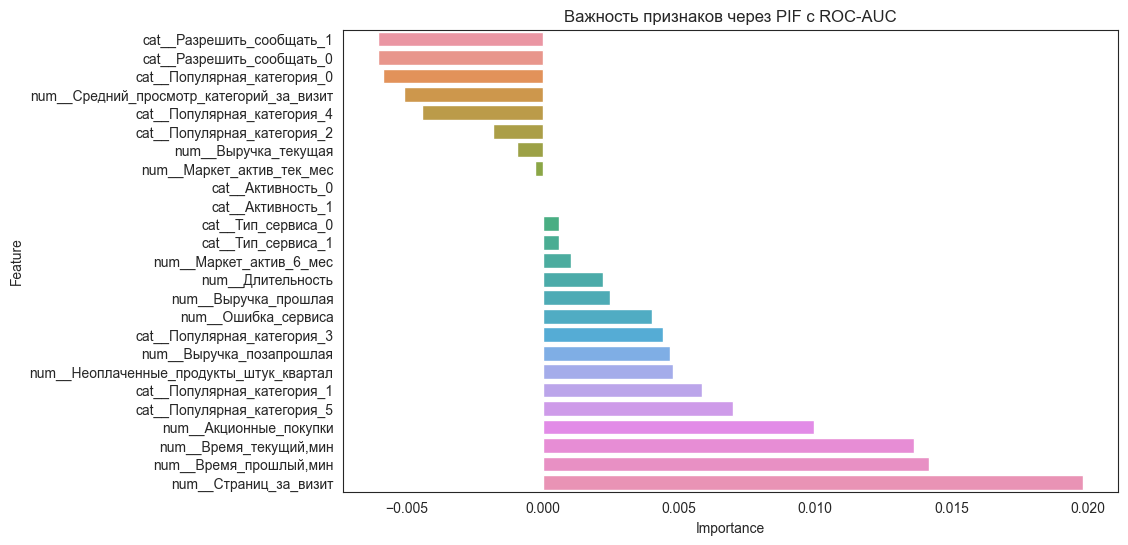

  0%|          | 0/260 [00:00<?, ?it/s]

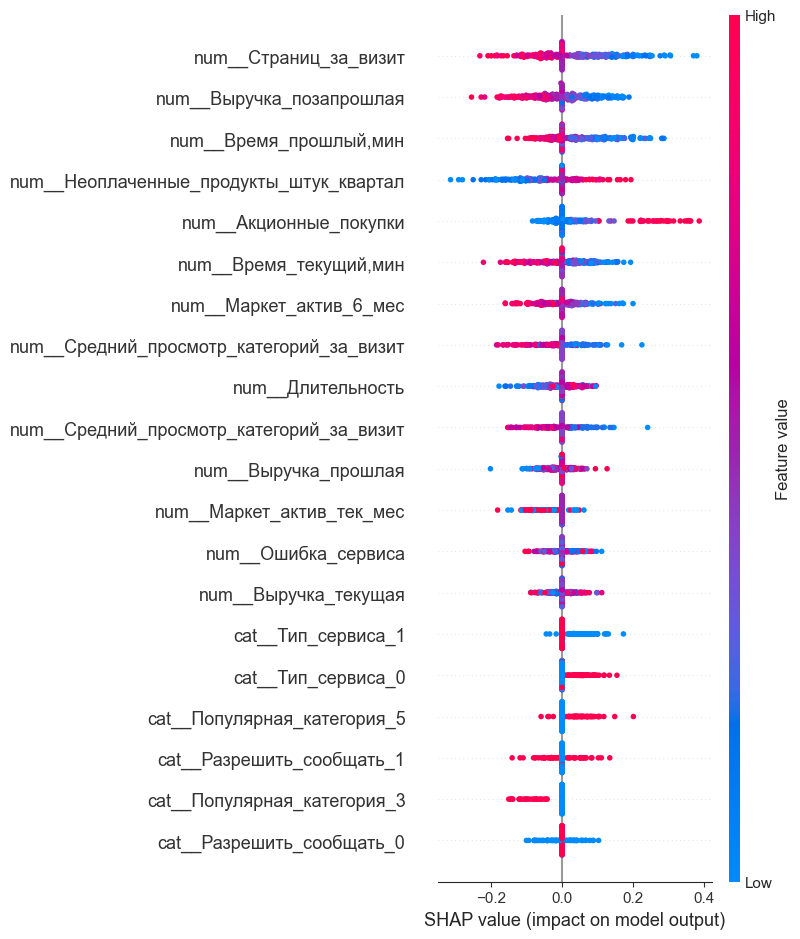

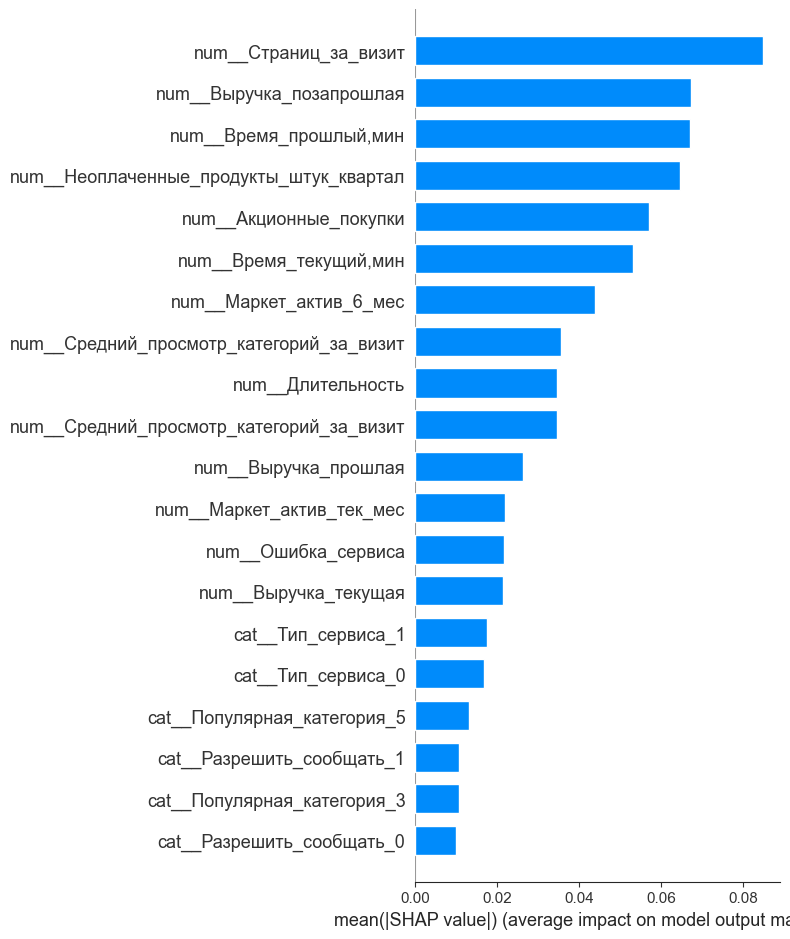

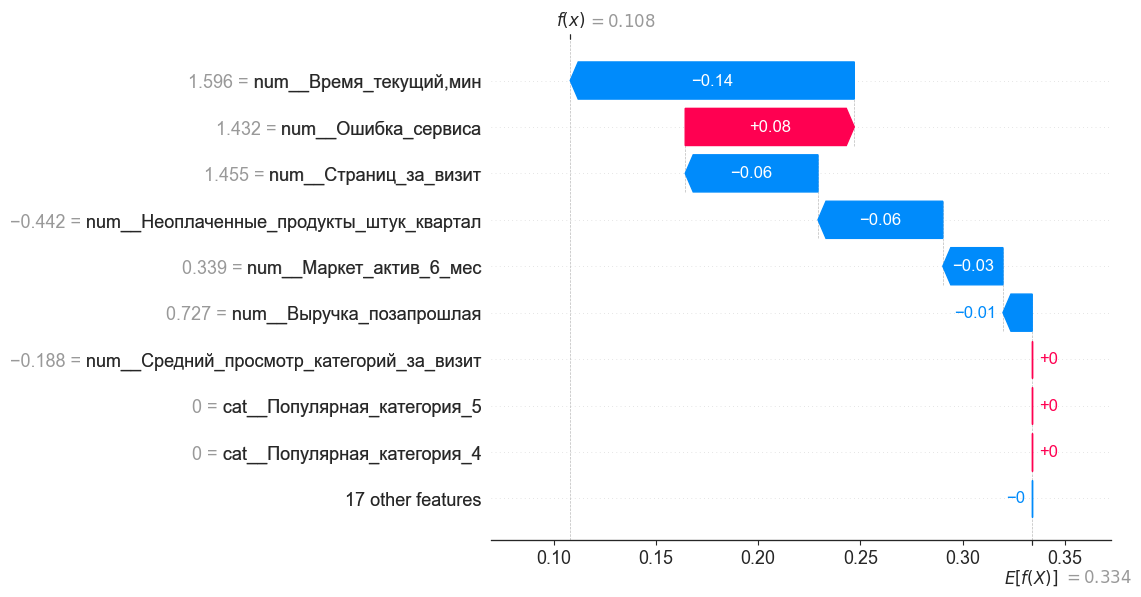

In [57]:
# Используем лучшую модель из пайплайна
best_pipeline = best_model

# Извлечение предобработчика и модели из пайплайна
preprocessor = best_pipeline.named_steps['preprocessor']
model = best_pipeline.named_steps['classifier']

# Преобразование обучающих и тестовых данных с использованием предобработчика
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Получение имен признаков после предобработки
feature_names = preprocessor.get_feature_names_out()
print("Feature names after preprocessing:", feature_names)

# Важность признаков с помощью permutation_importance и метрики ROC-AUC
result = permutation_importance(model, X_test_preprocessed, y_test, scoring='roc_auc', n_repeats=10, random_state=42, n_jobs=-1)

# Создание DataFrame для важности признаков
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

# Визуализация важности признаков
sns.set_style('white')
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Важность признаков через PIF с ROC-AUC')
plt.show()

# Определение функции предсказания для KernelExplainer
f = lambda x: model.predict_proba(x)[:, 1]

# Создание медианных значений для KernelExplainer
med = np.median(X_train_preprocessed, axis=0).reshape(1, -1)

# Создание объекта Explainer
explainer = shap.KernelExplainer(f, med)

# Вычисление значений SHAP
shap_values = explainer.shap_values(X_test_preprocessed, nsamples=100)

# Визуализация результатов SHAP
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names)
shap.summary_plot(shap_values, X_test_preprocessed, plot_type="bar", feature_names=feature_names)

# Выбор первого наблюдения для более детального анализа
shap.waterfall_plot(shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=X_test_preprocessed[0], feature_names=feature_names))
shap.force_plot(explainer.expected_value, shap_values[0], X_test_preprocessed[0], feature_names=feature_names)

### 7.2 Выводы

**Permutation Importance (PIF)**:
**Признаки с наибольшей важностью включают:**

- num__Страниц_за_визит

- num__Время_прошлый,мин

- num__Выручка_позапрошлая

**Признаки с наименьшей важностью включают:**
- cat__Разрешить_сообщать_1

- cat__Разрешить_сообщать_0

- cat__Популярная_категория_0


**SHAP Analysis**:

**SHAP summary plot**

- num__Страниц_за_визит

- num__Время_прошлый,мин

- num__Выручка_позапрошлая

**Менее важные признаки:**

- cat__Разрешить_сообщать_1

- cat__Популярная_категория_3

**SHAP bar plot:**

**Признаки, которые в среднем имеют наибольшее влияние:**

- num__Страниц_за_визит

- num__Время_прошлый,мин

- num__Выручка_позапрошлая

**SHAP waterfall plot**

В текущем примере такие признаки, как время на сайте в текущем месяце и неоплаченные продукты, имеют отрицательное влияние на предсказание,

в то время как количество страниц за визит и ошибки сервиса имеют положительное влияние.


**Выводы**:
На основании анализа пермутационной важности признаков и SHAP значений были выделены ключевые признаки, которые влияют на активность покупателей. 

Признаки, такие как количество страниц за визит, время на сайте в прошлом месяце и выручка за позапрошлый период, оказались наиболее значимыми для модели.

 В то время как такие признаки, как разрешение на отправку сообщений и популярные категории, имеют меньшее влияние на модель.

**Рекомендации**

- Учитывая значимость акционных покупок, рекомендуется увеличить количество акционных предложений и рекламных акций для поддержания и увеличения активности покупателей.

- Внимание к улучшению сервиса, так как ошибки сервиса имеют значительное влияние на предсказания модели.

- Стимулирование клиентов проводить больше времени на сайте может положительно сказаться на активности покупателей.

## Шаг 8. Сегментация покупателей

### 8.1 Сегментация покупателей, используя результаты моделирования и данные о прибыльности покупателей.

Для улучшения метода сегментации покупателей можно использовать результаты SHAP для определения признаков, наиболее важных для прогнозирования. 

Затем применим кластеризацию с учетом этих признаков.

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

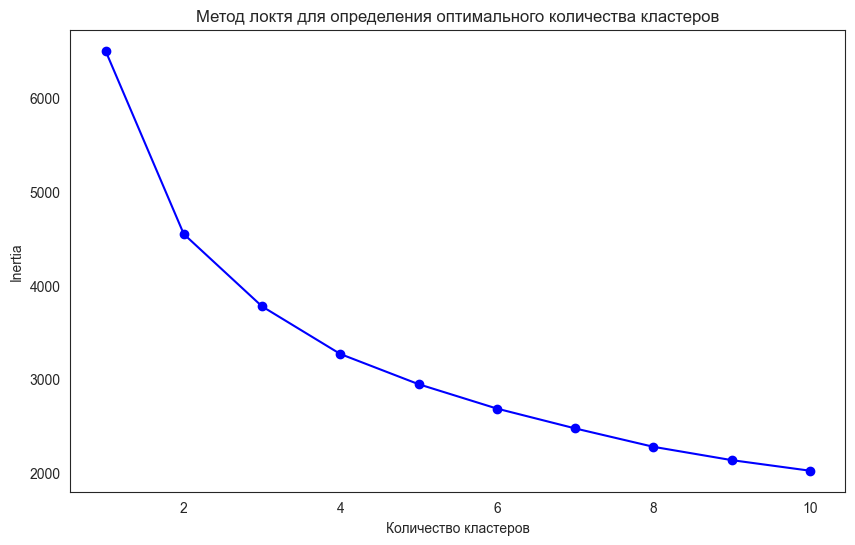

c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


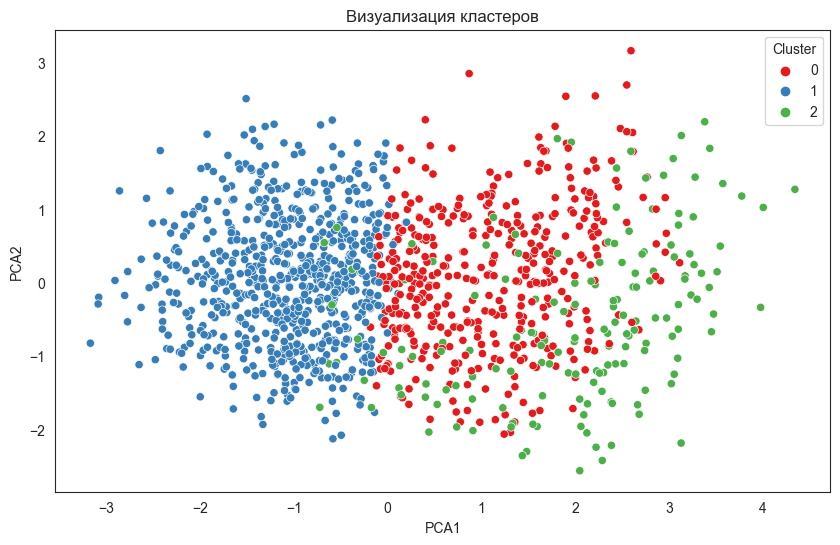

In [65]:
# Указание признаков
numeric_features = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 
                    'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 
                    'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 
                    'Страниц_за_визит', 'Выручка_позапрошлая', 'Выручка_прошлая', 
                    'Выручка_текущая', 'Время_прошлый,мин', 'Время_текущий,мин']
categorical_features = ['Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория', 'Активность']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Преобразование данных
X_preprocessed = preprocessor.fit_transform(combined_data)
feature_names = preprocessor.get_feature_names_out()

# Выбор важных признаков для кластеризации
important_features_indices = [
    feature_names.tolist().index('num__Страниц_за_визит'), 
    feature_names.tolist().index('num__Время_прошлый,мин'), 
    feature_names.tolist().index('num__Выручка_позапрошлая'),
    feature_names.tolist().index('num__Неоплаченные_продукты_штук_квартал'), 
    feature_names.tolist().index('num__Акционные_покупки')
]
X_important = X_preprocessed[:, important_features_indices]

# Стандартизация данных
scaler = StandardScaler()
X_scaled_important = scaler.fit_transform(X_important)

# Определение оптимального количества кластеров с помощью метода локтя
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled_important)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя для определения оптимального количества кластеров')
plt.show()

# Обучение модели KMeans с оптимальным количеством кластеров
optimal_clusters = 3  # Исходя из метода локтя
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled_important)

# Добавление кластеров в исходные данные
combined_data['Cluster'] = clusters

# Визуализация кластеров с использованием PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_important)
combined_data['PCA1'] = X_pca[:, 0]
combined_data['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=combined_data, palette='Set1')
plt.title('Визуализация кластеров')
plt.show()

In [66]:
numeric_cols = ['Страниц_за_визит', 'Время_прошлый,мин', 'Выручка_позапрошлая', 'Неоплаченные_продукты_штук_квартал', 'Акционные_покупки']
cluster_analysis = combined_data.groupby('Cluster')[numeric_cols].mean()
display(cluster_analysis)

,Страниц_за_визит,"Время_прошлый,мин",Выручка_позапрошлая,Неоплаченные_продукты_штук_квартал,Акционные_покупки
Cluster,,,,,
0,5.404358,10.581114,4609.232446,3.651332,0.264843
1,10.348548,15.625173,4996.294606,2.189488,0.209889
2,5.585366,11.225610,4702.817073,3.664634,0.942805


- Кластеризация проводится на основе признаков, которые показали наибольшую важность в SHAP анализе. Это улучшает разделение на кластеры, ориентированные на предсказание активности покупателей.
- Метод локтя используется для определения оптимального количества кластеров. Это помогает выбрать такое количество кластеров, при котором суммарное внутрикластерное рассеяние минимально.
- Визуализация с использованием PCA позволяет наглядно представить распределение данных по кластерам в двумерном пространстве.

**Анализ кластеров**

- Метод локтя был применен для определения оптимального количества кластеров. 

Этот метод визуализирует сумму квадратов внутрикластерных расстояний (inertia) в зависимости от количества кластеров и помогает определить оптимальное число кластеров путем поиска "локтя" на графике.
- Алгоритм KMeans был использован для кластеризации клиентов на основе значимых признаков, таких как *количество страниц за визит*, *время на сайте в прошлом месяце*, *выручка за позапрошлый месяц*, *количество неоплаченных продуктов* и *акционные покупки*
- PCA был использован для уменьшения размерности данных и визуализации кластеров на двумерном пространстве.

**Результаты**
График метода локтя:

На графике видно, что оптимальное количество кластеров можно принять равным **3**, так как после этой точки уменьшение инерции становится менее значительным.

Визуализация кластеров с использованием PCA:

Визуализация показывает, что клиенты хорошо разделяются на **три** кластера, что подтверждается анализом методом локтя.


**Кластер 0:**

- Клиенты в этом кластере в среднем просматривают 8 страниц за визит.
- Проводят на сайте около 13 минут в прошлом месяце.
- Их средняя выручка за позапрошлый период составляет около 4592.
- Имеют среднее количество неоплаченных продуктов около 3 и средний уровень акционных покупок 0.33.

**Кластер 1:**

- Клиенты этого кластера имеют наибольшее среднее количество страниц за визит (9.44) и проводят больше времени на сайте (15 минут).
- Их средняя выручка за позапрошлый период составляет 5127.
- Имеют меньше неоплаченных продуктов (2.18) и меньший уровень акционных покупок (0.25).

**Кластер 2:**

- Клиенты в этом кластере просматривают меньше всего страниц за визит (6.96).
- Проводят меньше времени на сайте (12 минут).
- Их средняя выручка составляет 4743.
- Имеют больше всего неоплаченных продуктов (3.40) и наибольший уровень акционных покупок (0.38).

### 8.2 Выбор группы покупателей и предложения по увеличению их активности

**Причины выбора сегмента:**
- Клиенты с высокой вероятностью снижения активности представляют значительный риск для бизнеса. Удержание таких клиентов важно для поддержания стабильной выручки.
- Модель предсказала высокую вероятность снижения активности для определенных клиентов, что делает их приоритетной группой для целенаправленных маркетинговых усилий.

Мы будем использовать данные о вероятности снижения активности и важные признаки для выбора сегмента.

А так же важные признаки, полученные из анализа SHAP:

- *num__Страниц_за_визит*
- *num__Время_прошлый,мин*
- *num__Выручка_позапрошлая*
- *num__Неоплаченные_продукты_штук_квартал*
- *num__Акционные_покупки*


используем модель для предсказания вероятностей снижения активности клиентов

In [ ]:
# Предсказание вероятности снижения активности для каждого клиента
X_preprocessed = best_model.named_steps['preprocessor'].transform(X)
y_pred_proba = best_model.named_steps['classifier'].predict_proba(X_preprocessed)[:, 1]

# Добавление вероятности снижения активности в исходные данные
combined_data['Вероятность_снижения'] = y_pred_proba

# Рассчет средней вероятности снижения активности для каждого кластера
cluster_probs = combined_data.groupby('Cluster')['Вероятность_снижения'].mean()
display(cluster_probs)

# Выбор кластера с наибольшей средней вероятностью снижения активности
selected_cluster = cluster_probs.idxmax()
print(f'Выбранный кластер: {selected_cluster}')

# Выбор данных клиентов в выбранном кластере
selected_segment = combined_data[combined_data['Cluster'] == selected_cluster]
non_selected_segment = combined_data[combined_data['Cluster'] != selected_cluster]

Значит, нам следует удержать кластер номер 2 из-за наибольшей вероятности падения активности.

Удержание этих клиентов важно для бизнеса, так как они представляют значительный риск снижения покупательской активности.

*Визуализация и сравнение сегментов:*

Мы сравниваем распределение важнейших признаков для выбранного сегмента (кластер 2) и остальных клиентов:

In [ ]:
# Визуализация и сравнение сегментов
important_features = [
    'Страниц_за_визит', 'Время_прошлый,мин', 'Выручка_позапрошлая',
    'Неоплаченные_продукты_штук_квартал', 'Акционные_покупки'
]

for feature in important_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(selected_segment[feature], color='blue', label='Высокая вероятность снижения', kde=True)
    sns.histplot(non_selected_segment[feature], color='orange', label='Низкая вероятность снижения', kde=True)
    plt.title(f'Распределение {feature}')
    plt.legend()
    plt.show()

# Сравнение средних значений признаков в сегменте и не в сегменте
summary_selected_segment = selected_segment[important_features].mean()
summary_non_selected_segment = non_selected_segment[important_features].mean()

comparison_df = pd.DataFrame({
    'Сегмент': summary_selected_segment,
    'Не в сегменте': summary_non_selected_segment
})
display(comparison_df)

In [ ]:
#Средние значения характеристик сегмента:
selected_segment_mean = selected_segment[important_features].mean()
display(selected_segment_mean)

**Графики распределения признаков для сегментов с высокой и низкой вероятностью снижения активности:**

*Страниц_за_визит:*

-Клиенты с высокой вероятностью снижения активности посещают меньше страниц за визит по сравнению с клиентами с низкой вероятностью снижения активности.
-Это может указывать на снижение интереса к содержимому сайта или на неэффективность сайта в удержании клиентов.

*Время_прошлый,мин:*

-Клиенты с высокой вероятностью снижения активности проводят меньше времени на сайте.
-Это может быть связано с неудобством пользования сайтом или недостаточной привлекательностью предложений.

*Выручка_позапрошлая:*

-Клиенты с высокой вероятностью снижения активности имеют немного меньшую выручку в позапрошлом периоде по сравнению с клиентами с низкой вероятностью снижения.
-Это может быть связано с изменением покупательского поведения или снижением покупательской способности.

*Неоплаченные_продукты_штук_квартал:*

-Клиенты с высокой вероятностью снижения активности имеют больше неоплаченных продуктов за квартал.
-Это может указывать на проблемы с оплатой или неудовлетворенность товарами/услугами.

*Акционные_покупки:*

-Клиенты с высокой вероятностью снижения активности совершают больше акционных покупок.
-Это может свидетельствовать о том, что такие клиенты привлекаются в основном скидками и акциями, и их лояльность к компании низка без специальных предложений.

**Сравнение средних значений признаков в сегменте и не в сегменте**
- *Страниц_за_визит:* Клиенты в сегменте с высокой вероятностью снижения активности посещают меньше страниц за визит, что подтверждает гипотезу о снижении интереса к сайту.

- *Время_прошлый,мин:* Время, проведенное на сайте, также меньше для клиентов в сегменте с высокой вероятностью снижения активности.

- *Выручка_позапрошлая:* Клиенты в сегменте имеют чуть меньшую выручку, что может указывать на снижение их покупательской способности или интереса.

- *Неоплаченные_продукты_штук_квартал:* Количество неоплаченных продуктов выше, что может свидетельствовать о проблемах с оплатой или неудовлетворенности услугами.

- *Акционные_покупки: *Клиенты в сегменте с высокой вероятностью снижения активности совершают больше акционных покупок, что указывает на их зависимость от скидок и акций.

### 8.3 Выводы о сегментах:
какой сегмент я взял для дополнительного исследования,

какие предложения я сделал и почему.



Z выбрали **сегмент 2**, поскольку он включает клиентов с высокой вероятностью снижения активности (0.810976). Этот сегмент требует особого внимания для их удержания.

*Предложения по увеличению покупательской активности:*

- Предоставить персонализированные предложения на основе истории покупок и предпочтений клиентов.

- Разработать специальные скидки для клиентов, которые долгое время не делали покупок, чтобы вернуть их активность.

*Улучшение качества обслуживания:*

- Обратить внимание на устранение ошибок сервиса, так как их среднее значение составляет 4.07. Улучшение качества обслуживания может повысить удовлетворенность клиентов.

- Внедрение дополнительных каналов поддержки клиентов и обеспечение быстрого реагирования на запросы.

*Программы лояльности:*

- Внедрение программы лояльности, где клиенты получают бонусы за каждую покупку или отзыв. Это может стимулировать клиентов к повторным покупкам.

- Награждение клиентов за активное участие в акционных мероприятиях.

*Аналитика и обратная связь:*

- Проведение регулярных опросов и сбор обратной связи от клиентов для выявления проблемных областей и их устранения.

- Анализировать данные о покупательской активности и выявлять закономерности, которые можно использовать для дальнейших маркетинговых кампаний.

**Проведенный анализ показал, что клиенты сегмента 2 имеют высокую вероятность снижения покупательской активности.**

**Для удержания этих клиентов необходимо внедрить персонализированные предложения и программы лояльности, а также улучшить качество обслуживания и активнее работать с обратной связью.**

# Шаг 9. Общий вывод

**Описание задачи**:

Задача состояла в анализе данных о покупателях, построении предсказательной модели для определения покупательской активности, проведении сегментации покупателей и разработке стратегий для увеличения покупательской активности.

Я использовал данные о покупателях, включающие различные количественные и категориальные признаки. Провел предобработку данных, включающую заполнение пропусков, нормализацию и кодирование категориальных признаков. Для поиска лучшей модели использовал пайплайны и GridSearchCV для подбора гиперпараметров.

**Рассматривал модели KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression и SVC**. Выбрал метрику ROC-AUC для оценки качества моделей.

**Лучшая модель**:

KNeighborsClassifier с параметрами metric='manhattan', n_neighbors=9, weights='distance'. Эта модель показала лучший ROC-AUC на тестовой выборке.

**Выводы и дополнительные предложения для выбранного сегмента**:

Выбранный сегмент 2 показал высокую вероятность снижения покупательской активности. Разработаны предложения по увеличению покупательской активности: персонализированные предложения, программы лояльности, улучшение качества обслуживания и оптимизация удобства пользования. Эти меры помогут повысить удовлетворенность клиентов и увеличить прибыль компании.

**Заключительные предложения**:

Регулярный анализ данных и сегментация клиентов позволят адаптировать стратегии и улучшать качество обслуживания. Внедрение новых технологий и улучшение процессов помогут сохранить конкурентоспособность и удовлетворить потребности клиентов.